# Predictive and Descriptive Analysis - Group Project

### Advanced analytics in fundraising: how knowing donors helps in growing donors 

 Group 1: Noémie GAUTIER, Théau BRUNO, Thomas HENRY, Laura El Aoufir

In [1]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from pandas                 import DataFrame
from pandas                 import Series
from pandas                 import read_csv
from pandas                 import get_dummies
from numpy                  import array
from numpy                  import random
from numpy                  import where
from numpy                  import nan
from scipy.stats.mstats     import winsorize
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from scipy.stats            import pearsonr
from sklearn.metrics        import roc_curve
from matplotlib             import pyplot


!pip install pandasql
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())  # Allow sqldf to access global environment

In [2]:
# Pr. Houdart functions

from pandas             import DataFrame
from pandas             import Series
from pandas             import read_csv
from numpy              import array
from numpy              import random


def roc (dataSet: DataFrame, actuals: str, probability: str) -> DataFrame:

    (fpr,tpr,threshold) = roc_curve(array(dataSet[actuals]), array(dataSet[probability]), pos_label = 1)

    returnData = DataFrame(tpr)
    returnData.columns = ["True positive rate"]
    returnData["False positive rate"] = DataFrame(fpr)

    return returnData

def lift (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    summary = cumulativeResponse(dataSet = dataSet, actuals = actuals, probability = probability, precision = precision)

    summary["Lift"] = summary["Cumulative response"] / Series(summary["Average response"]).max()
    summary["Base"] = summary["Average response"] / Series(summary["Average response"]).max()

    return summary[["Quantile","Lift","Base"]]

def cumulativeResponse (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative response"]  = summary["cumulativeTarget"] / summary["cumulativeAll"]
    summary["Average response"]     = Series(summary["cumulativeTarget"]).max() / Series(summary["cumulativeAll"]).max()

    return summary[["Quantile","Cumulative response","Average response"]]

def cumulativeGains (dataSet: DataFrame, actuals: str, probability: str, precision: int = 20) -> DataFrame:

    internalSet = equifrequentBinning (dataSet = dataSet[[actuals, probability]], byColumn = probability, into = precision)

    internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
    internalSet["obs"]      = 1

    summary = internalSet[["Quantile", actuals, "obs"]].groupby(["Quantile"], as_index = False).sum().sort_values(by = "Quantile", ascending = False)

    summary["cumulativeTarget"]     = Series(summary[actuals]).cumsum(skipna = False)
    summary["cumulativeAll"]        = Series(summary["obs"]).cumsum(skipna = False)
    summary["Cumulative gains"]     = summary["cumulativeTarget"] / Series(summary["cumulativeTarget"]).max()
    summary["Base"]                 = summary["Quantile"]

    return summary[["Quantile","Cumulative gains","Base"]]

def equifrequentBinning (dataSet: DataFrame, byColumn: str, into: int) -> DataFrame:

    internalSet = dataSet

    quanitles = []

    for i in range(into):
        quanitles.append(1 / into * (i))

    quantile = internalSet.quantile(quanitles, axis = 0)[byColumn].to_dict()

    internalSet["Bin"] = 0

    for q in quantile:
        upperBound = quantile[q]
        internalSet.loc[internalSet[byColumn] >= upperBound, byColumn + "_bin"] = int(q * into +1)

    return internalSet

def partition (dataFrame : DataFrame, splitStrategy: [float]) -> [DataFrame]:

    def assignPartition (toDataFrame: DataFrame, lowerBound: float, upperBound: float, index: int) -> int:
        if toDataFrame["random"] >= lowerBound * observations and toDataFrame["random"] < upperBound * observations:
            return index
        else:
            return int(toDataFrame["Split"])

    if type(splitStrategy) != list:
        raise KeyError("Split strategy must be an array of floating point values.")
    elif sum(splitStrategy) != 1:
        raise ValueError("Split strategy must sum to 1.")
    else:
        observations = dataFrame.shape[0]
        partitions   = len(splitStrategy)

        cumulativeSplit = 0

        data = dataFrame.copy()
        data["random"] = random.permutation(observations)
        data["Split"]  = 0

    for index, split in enumerate(splitStrategy):
        lowerSplit = cumulativeSplit
        upperSplit = cumulativeSplit + split + 1
        cumulativeSplit += split
        data["Split"] = data.apply(lambda x: assignPartition(x,lowerSplit,upperSplit,index+1), axis = 1)

    partitions = []

    for i in range(len(splitStrategy)):
        partitions.append(data.loc[data["Split"] == i+1].drop(["Split","random"], axis = 1).reset_index(drop = True))

    return partitions


## Part I: Data Processing

In [3]:
# load the data
campaigns = pd.read_csv("campaigns.csv", sep = ";")
donors = pd.read_csv("donors.csv", sep = ";")
gifts = pd.read_csv("gifts.csv", sep = ";")
campaign_6169 = pd.read_csv("selection campaign 6169.csv", sep = ";")
campaign_7244 = pd.read_csv("selection campaign 7244.csv", sep = ";")

## Campaigns

In [4]:
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [5]:
campaigns.loc[campaigns.campaignID==6169]

,campaignID,date,lettersSent,CostUnit
335,6169,04/09/2018,34 888,"0,87 €"


In [6]:
campaigns.shape

(367, 4)

In [7]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [8]:
campaigns.dtypes

campaignID      int64
date           object
lettersSent    object
CostUnit       object
dtype: object

In [9]:
for i in campaigns.columns:
    print(i, campaigns[i].unique())

campaignID [ 153  154  180  433  476  498  536  574  584  606  627  663  669  711
  723  767  768  796  804  816  850  858  899  901  930  954  968  979
  980 1000 1026 1028 1034 1058 1074 1101 1148 1149 1153 1181 1185 1207
 1212 1218 1235 1245 1248 1280 1316 1317 1331 1338 1343 1374 1377 1397
 1400 1424 1428 1465 1489 1490 1513 1529 1544 1556 1568 1577 1601 1615
 1626 1634 1636 1663 1664 1678 1698 1699 1736 1739 1755 1775 1778 1790
 1808 1843 1844 1851 1861 1875 1878 1903 1904 1917 1929 1933 1949 1962
 1966 1991 1992 2021 2029 2035 2040 2059 2090 2094 2105 2123 2129 2133
 2144 2163 2193 2194 2224 2225 2231 2232 2233 2256 2263 2285 2296 2319
 2335 2351 2360 2389 2390 2414 2415 2416 2417 2451 2470 2485 2498 2534
 2550 2553 2566 2577 2579 2580 2632 2633 2646 2653 2654 2677 2695 2710
 2711 2712 2713 2714 2802 2838 2871 2872 2905 2908 2916 2945 2963 2964
 2994 3016 3033 3049 3064 3079 3083 3108 3125 3129 3183 3184 3186 3187
 3188 3189 3236 3249 3254 3277 3300 3318 3330 3346 3348 3356 3357 

#### Converting variables data types

In [10]:
# date
campaigns['date'] = pd.to_datetime(campaigns['date'].astype('str'),format='%d/%m/%Y')

In [11]:
# lettersSent
campaigns['lettersSent'] = campaigns['lettersSent'].str.replace('\u202f','')

campaigns.rename({'lettersSent':'letters_sent'},axis=1,inplace=True)

In [12]:
# CostUnit
# replacing ',' by decimal points because French language reads commas as decimal points
campaigns['CostUnit'] = campaigns['CostUnit'].str.replace(',','.')
campaigns['CostUnit'] = campaigns['CostUnit'].str.replace(r'[^0-9.]+','')
campaigns.rename({'CostUnit':'cost_per_letter'},axis=1,inplace=True)

In [13]:
campaigns.head()

,campaignID,date,letters_sent,cost_per_letter
0,153,2004-12-13,6873,0.17
1,154,2005-01-01,7656,0.30
2,180,2005-01-18,9933,0.20
3,433,2005-01-29,7448,0.59
4,476,2005-02-12,6605,0.51


## Donors

In [14]:
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25


In [15]:
donors.shape

(44691, 7)

In [16]:
donors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  int64  
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.4+ MB


In [17]:
donors.dtypes

donorID          int64
zipcode        float64
province        object
region          object
gender          object
language        object
dateOfBirth     object
dtype: object

In [18]:
for i in donors.columns:
    print(i, donors[i].unique())

donorID [100001 100002 100003 ... 144689 144690 144691]
zipcode [1861. 2260. 1780. ... 6594. 6833. 6692.]
province ['Flemish Brabant' 'Antwerp' 'Brussels' 'Walloon Brabant' 'West Flanders'
 'East Flanders' 'Liege' 'Luxembourg' 'Namur' 'Hainaut' 'Limburg'
 'Missing']
region ['Flanders' 'Brussels' 'Wallonia' 'Missing']
gender ['F' 'M' nan]
language ['NL' 'FR' 'EN']
dateOfBirth ['1967-12-24' '1952-01-14' '1986-12-23' ... '1984-05-16' '1952-02-05'
 '1984-11-22']


### dealing with missing values

#### creating 'is_missing' variables for variables with missing values

In [19]:
donors["gender_is_missing"] = where(donors["gender"].isnull(), 1, 0)
donors["zipcode_is_missing"] = where(donors["zipcode"].isnull(), 1, 0)
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth,gender_is_missing,zipcode_is_missing
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,0,0
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,0,0
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,0,0
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,0,0
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,0,0


#### missing zipcode, province and region

In [20]:
# locating the missing values
donors.loc[donors.zipcode.isna()]

,donorID,zipcode,province,region,gender,language,dateOfBirth,gender_is_missing,zipcode_is_missing
5019,105020,NaN,Missing,Missing,M,EN,1966-11-09,0,1
22100,122101,NaN,Missing,Missing,F,EN,1975-10-31,0,1


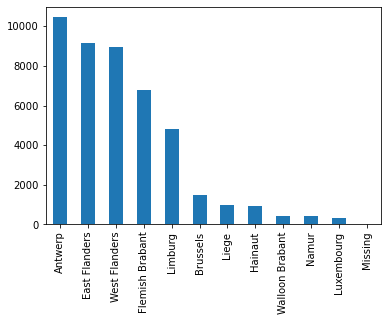

In [21]:
# checking the distribution of donors per province
donors['province'].value_counts().plot.bar()

In [22]:
# replacing the missing values with the most frequent value (mode)
donors.loc[donors.province == 'Missing','province'] = 'Antwerp'
donors.loc[donors.province == 'Antwerp','region'] = 'Flanders'
donors.loc[donors.province == 'Antwerp','zipcode'] = 2260

#### missing gender

In [23]:
# checking missing values in 'gender', data seem to be missing completely at random
donors.loc[donors.gender.isnull()]

,donorID,zipcode,province,region,gender,language,dateOfBirth,gender_is_missing,zipcode_is_missing
83,100084,1500.0,Flemish Brabant,Flanders,NaN,NL,1950-03-16,1,0
217,100218,1300.0,Walloon Brabant,Wallonia,NaN,FR,1979-08-04,1,0
512,100513,1933.0,Flemish Brabant,Flanders,NaN,NL,1952-03-17,1,0
552,100553,1560.0,Flemish Brabant,Flanders,NaN,FR,1952-12-05,1,0
729,100730,2260.0,Antwerp,Flanders,NaN,NL,1959-11-09,1,0
883,100884,2260.0,Antwerp,Flanders,NaN,NL,1977-10-28,1,0
1056,101057,2260.0,Antwerp,Flanders,NaN,NL,1938-04-20,1,0
2050,102051,3650.0,Limburg,Flanders,NaN,NL,1936-08-16,1,0
2209,102210,3970.0,Limburg,Flanders,NaN,NL,1980-04-05,1,0
2379,102380,5080.0,Namur,Wallonia,NaN,FR,1982-06-30,1,0


In [24]:
# checking count of missing values in 'gender' per province to identify a possible trend
df_filled = donors.fillna('missing')

donors_pv1 = df_filled.pivot_table(index='province',
                                columns='gender',  # Group by
                                values='donorID',  # Column to aggregate
                                aggfunc='count')   # Aggregate function

donors_pv1 = pd.DataFrame(donors_pv1).sort_values('M', ascending=False)

donors_pv1['more_females'] = donors_pv1.loc[:,'M']<donors_pv1.loc[:,'F']

donors_pv1

gender,F,M,missing,more_females
province,,,,
Antwerp,4461.0,5986.0,5.0,False
East Flanders,3812.0,5322.0,3.0,False
West Flanders,3791.0,5166.0,7.0,False
Flemish Brabant,2784.0,3992.0,5.0,False
Limburg,2035.0,2777.0,6.0,False
Brussels,623.0,863.0,2.0,False
Hainaut,412.0,532.0,NaN,False
Liege,444.0,524.0,2.0,False
Walloon Brabant,185.0,247.0,1.0,False


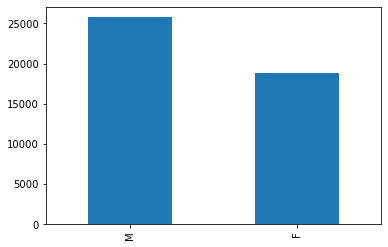

In [25]:
# plotting the number of males/females overall to visualize the Euclidean distance
donors['gender'].value_counts().plot.bar()

In [26]:
# replacing missing values in 'gender' by 'M'
donors.gender.fillna('missing', inplace=True)
donors.loc[donors.gender == 'missing','gender'] = 'M'
donors.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth,gender_is_missing,zipcode_is_missing
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,0,0
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,0,0
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,0,0
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,0,0
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,0,0


#### Converting variables data types

In [27]:
# dateOfBirth
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'].astype('str'),format='%Y-%m-%d')
donors.rename({'dateOfBirth':'DOB'},axis=1,inplace=True)

In [28]:
# zipcode
donors['zipcode'] = donors['zipcode'].astype(int)

### Dealing with outliers

In [29]:
print(donors['zipcode'].min())
print(donors['zipcode'].max())

0
9992


In [30]:
donors.loc[donors.zipcode == 0]

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing
15231,115232,0,Walloon Brabant,Wallonia,M,FR,1932-02-06,0,0


## Gifts

In [31]:
gifts.head()

,donorID,campaignID,amount,date
0,100001,NaN,12.39,2004-03-23
1,100001,1577.0,12.39,2007-10-11
2,100001,1634.0,6.69,2007-12-28
3,100001,1778.0,24.79,2008-06-14
4,100001,1808.0,7.44,2008-07-09


In [32]:
gifts.shape

(216594, 4)

In [33]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  int64  
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  float64
 3   date        216594 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 6.6+ MB


In [34]:
gifts.dtypes

donorID         int64
campaignID    float64
amount        float64
date           object
dtype: object

In [35]:
for i in gifts.columns:
    print(i, gifts[i].unique())

donorID [ 100001  100002  100003 ...  317880  480980 1474536]
campaignID [  nan 1577. 1634. 1778. 1808. 1933. 2094. 2335. 2550. 2653. 2714. 3049.
 3941. 4801. 4830. 4990. 5326. 5359. 6168. 6922. 7037. 7074. 7090. 7212.
 7243.  711.  767.  901.  930. 1148. 1218. 1248. 1338. 1343. 1489. 1626.
 1663. 1790. 1929. 1949. 1991. 2021. 2105. 2256. 2319. 2360. 1212. 1245.
 4500. 7108. 2123. 2296. 2711. 2994. 3254. 3449. 3786. 4148. 5062. 1428.
 1601. 2963.  954. 1317. 1903. 2035. 2144. 2193. 2351. 2485. 2566. 2710.
 2905. 3033. 3125. 4213. 4210. 2414. 4223. 4674. 4685. 4687. 3528. 3816.
 1185. 1424. 1755. 1966. 2285. 2713. 1026. 1058. 1374. 1739. 2470. 3505.
 3664. 6169. 7346.  796.  858. 1000. 1101. 1465. 3129.  768.  816.  979.
 1280. 1397. 1529. 1556. 1699. 1736. 1843. 1878. 1962. 2059. 2133. 2224.
 2233. 2389. 2451. 2498. 2534. 2553. 2632. 2695. 2712. 2838. 2871. 2945.
 2964. 3016. 3079. 3183. 3184. 3187. 3188. 3189. 3236. 3277. 3300. 3346.
 3440. 3441. 3443. 3444. 3445. 3448. 3527. 3565. 36

### Dealing with missing values

#### Creating 'is_missing' variables for variables with missing values

In [36]:
gifts["campaignID_is_missing"] = where(gifts["campaignID"].isnull(), 1, 0)

In [37]:
# checking missing values in 'campaignID', data seem to be missing completely at random
gifts.loc[gifts.campaignID.isnull()]

,donorID,campaignID,amount,date,campaignID_is_missing
0,100001,NaN,12.39,2004-03-23,1
29,100004,NaN,24.79,2006-03-30,1
57,100007,NaN,24.79,2006-09-04,1
112,100020,NaN,24.79,2001-12-05,1
181,100025,NaN,20.00,2009-05-29,1
...,...,...,...,...,...
216506,144666,NaN,32.25,2010-10-11,1
216507,144667,NaN,49.58,2004-02-01,1
216514,144668,NaN,20.00,2019-11-20,1
216560,144683,NaN,50.00,2015-10-11,1


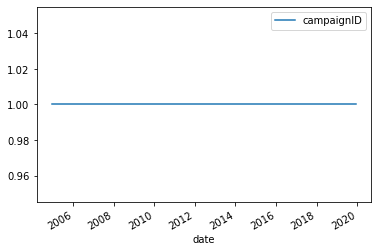

In [38]:
# checking number of campaigns per date
campaigns_date = pd.DataFrame(campaigns.groupby('date')['campaignID'].count())
campaigns_date.reset_index()
campaigns_date.plot()

In [39]:
# resetting the dataframe index
campaigns_date.reset_index(inplace=True)
campaigns_date.head()

,date,campaignID
0,2004-12-13,1
1,2005-01-01,1
2,2005-01-18,1
3,2005-01-29,1
4,2005-02-12,1


In [40]:
# calculating time diff between 2 campaigns and chekcing the minimum
campaigns_date['diff_days'] = campaigns_date.loc[:,'date'] - campaigns_date.loc[:,'date'].shift(1)
campaigns_date['diff_days'].min()

Timedelta('10 days 00:00:00')

### Dealing with outliers

In [41]:
dict = gifts['amount'].quantile([.01,.05,.95,.99]).to_dict()

# checking for outliers
gifts[gifts['amount'] >= dict[.99]][['donorID','amount']]

,donorID,amount
402,100061,226.00
573,100104,732.00
967,100191,200.00
969,100191,200.00
1368,100280,123.95
...,...,...
216577,144689,200.00
216582,210268,300.00
216589,265584,300.00
216591,317880,157.50


In [42]:
# winsorizing to take out outliers
gifts["winsorized_amount"] = winsorize(array(gifts['amount']), limits=[0.00,0.01])
gifts['winsorized_amount'].max()

123.95

#### Converting variables data types

In [43]:
# date
gifts['date'] = pd.to_datetime(gifts['date'].astype('str'),format='%Y-%m-%d')

In [44]:
# campaignID
gifts.fillna(0,inplace=True)
gifts['campaignID'] = gifts['campaignID'].astype(int)

## Campaign 6169

In [45]:
campaign_6169.head()

,donorID
0,100001
1,100002
2,100004
3,100008
4,100009


In [46]:
campaign_6169.shape

(34888, 1)

In [47]:
campaign_6169.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  34888 non-null  int64
dtypes: int64(1)
memory usage: 272.7 KB


In [48]:
campaign_6169.dtypes

donorID    int64
dtype: object

In [49]:
for i in campaign_6169.columns:
    print(i, campaign_6169[i].unique())

donorID [100001 100002 100004 ... 144689 144690 144691]


In [50]:
print(campaigns.loc[campaigns.campaignID==6169].date)
print(gifts.loc[gifts.campaignID==6169].date.min())
print(gifts.loc[gifts.campaignID==6169].date.max())
print(gifts.loc[gifts.campaignID==6169].date.mean())

335   2018-09-04
Name: date, dtype: datetime64[ns]
2018-09-06 00:00:00
2018-09-24 00:00:00
2018-09-15 04:38:05.138541312


## Campaign 7244

In [51]:
campaign_7244.head()

,donorID
0,100001
1,100002
2,100008
3,100009
4,100010


In [52]:
campaign_7244.shape

(25645, 1)

In [53]:
campaign_7244.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  25645 non-null  int64
dtypes: int64(1)
memory usage: 200.5 KB


In [54]:
campaign_7244.dtypes

donorID    int64
dtype: object

In [55]:
for i in campaign_7244.columns:
    print(i, campaign_7244[i].unique())

donorID [100001 100002 100008 ... 144686 144690 144691]


In [56]:
print(campaigns.loc[campaigns.campaignID==7244].date)
print(gifts.loc[gifts.campaignID==7244].date.min())
print(gifts.loc[gifts.campaignID==7244].date.max())
print(gifts.loc[gifts.campaignID==7244].date.mean())

354   2019-06-18
Name: date, dtype: datetime64[ns]
2019-06-20 00:00:00
2019-07-08 00:00:00
2019-06-29 09:30:24.930747904


### Bonus

## Part II: Creation of variables for machine learning

## Donors

In [57]:
date_campaign_6169 = pd.to_datetime('2018-09-04')
date_campaign_7244 = pd.to_datetime('2019-06-18')

# calculation of age at the time of the campaigns
donors['age_campaign_6169'] = (date_campaign_6169 - donors['DOB']).astype('<m8[Y]').astype(int)
donors['age_campaign_7244'] = (date_campaign_7244 - donors['DOB']).astype('<m8[Y]').astype(int)

# creating age groups
donors['age_group_campaign_6169'] = donors['age_campaign_6169']//10*10
donors['age_group_campaign_7244'] = donors['age_campaign_7244']//10*10

In [58]:
# is_male variable
donors['is_male'] = where(donors["gender"]=='M', 1, 0)

In [59]:
# language is NL

# changing ENG to FR
donors['language'] = where(donors["language"]=='NL', 'NL', 'FR')

# is_NL_Language variable
donors['is_NL_speaker'] = where(donors["language"]=='NL', 1, 0)

In [60]:
# getting dummies for region and province variables (0/1)
donors = donors.join(get_dummies(donors["region"], prefix = "region_is"))
donors = donors.join(get_dummies(donors["province"], prefix = "province_is"))

In [61]:
donors.head()

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,province_is_Brussels,province_is_East Flanders,province_is_Flemish Brabant,province_is_Hainaut,province_is_Liege,province_is_Limburg,province_is_Luxembourg,province_is_Namur,province_is_Walloon Brabant,province_is_West Flanders
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,0,0,50,...,0,0,1,0,0,0,0,0,0,0
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,0,0,66,...,0,0,0,0,0,0,0,0,0,0
2,100003,1780,Flemish Brabant,Flanders,M,NL,1986-12-23,0,0,31,...,0,0,1,0,0,0,0,0,0,0
3,100004,1020,Brussels,Brussels,F,FR,1952-03-29,0,0,66,...,1,0,0,0,0,0,0,0,0,0
4,100005,1020,Brussels,Brussels,F,FR,1986-06-25,0,0,32,...,1,0,0,0,0,0,0,0,0,0


## Part III: Creating the training and test sets

### Training Set

In [62]:
# selecting the campaign dates
campaign_6169_date = campaigns.date[campaigns.campaignID==6169]
campaign_6169_date

335   2018-09-04
Name: date, dtype: datetime64[ns]

In [63]:
# isolating gifts info before the campaign
gifts_before_campaign_6169 = gifts[gifts.date.values < campaign_6169_date.values]
gifts_before_campaign_6169['date'].max()

Timestamp('2018-09-03 00:00:00')

In [64]:
# isolating gifts for the campaign
gifts_campaign_6169 = gifts[gifts.campaignID == 6169]

In [65]:
# isolating donors and their info selected for the campaign by left merging
campaign_6169_donors = pd.merge(campaign_6169,donors,how='left',on='donorID')
campaign_6169_donors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   donorID                      34888 non-null  int64         
 1   zipcode                      34874 non-null  float64       
 2   province                     34874 non-null  object        
 3   region                       34874 non-null  object        
 4   gender                       34874 non-null  object        
 5   language                     34874 non-null  object        
 6   DOB                          34874 non-null  datetime64[ns]
 7   gender_is_missing            34874 non-null  float64       
 8   zipcode_is_missing           34874 non-null  float64       
 9   age_campaign_6169            34874 non-null  float64       
 10  age_campaign_7244            34874 non-null  float64       
 11  age_group_campaign_6169      34874 non-nu

#### Dealing with missing values

In [66]:
# checking missing values
campaign_6169_donors[campaign_6169_donors['zipcode'].isna()]

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,province_is_Brussels,province_is_East Flanders,province_is_Flemish Brabant,province_is_Hainaut,province_is_Liege,province_is_Limburg,province_is_Luxembourg,province_is_Namur,province_is_Walloon Brabant,province_is_West Flanders
828,202036,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2182,205354,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4197,210268,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4361,1474536,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4891,317880,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5090,212406,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10648,225460,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13208,231512,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17033,480980,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22296,253280,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
# checking missing values
donors[donors['donorID']==225460]

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,province_is_Brussels,province_is_East Flanders,province_is_Flemish Brabant,province_is_Hainaut,province_is_Liege,province_is_Limburg,province_is_Luxembourg,province_is_Namur,province_is_Walloon Brabant,province_is_West Flanders


In [68]:
# creating an 'all_info_is_missing' column
campaign_6169_donors["all_info_is_missing"] = where(campaign_6169_donors["zipcode"].isnull(), 1, 0)
campaign_6169_donors.head()

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,province_is_East Flanders,province_is_Flemish Brabant,province_is_Hainaut,province_is_Liege,province_is_Limburg,province_is_Luxembourg,province_is_Namur,province_is_Walloon Brabant,province_is_West Flanders,all_info_is_missing
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,0.0,0.0,50.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,0.0,0.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,0.0,0.0,66.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,100008,1780.0,Flemish Brabant,Flanders,M,FR,1937-08-30,0.0,0.0,81.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,100009,1020.0,Brussels,Brussels,M,FR,1932-01-20,0.0,0.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


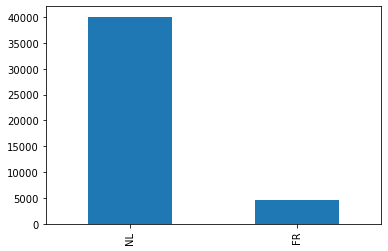

In [69]:
# plotting the number of donors per language to check
donors['language'].value_counts().plot.bar()

In [70]:
# replacing all NAs values by most common categorical value or mean
campaign_6169_donors.fillna('missing', inplace=True)

In [71]:
# replacing all NAs values by most common categorical value or mean

# list = [2260,'Antwerp','Flanders','M','NL','1967-12-24',1,1,49.43,50.22,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1]

# leaving the DOB alone and converting it back to datetime
DOB = pd.Timestamp('1967-12-24')
campaign_6169_donors.loc[campaign_6169_donors['DOB']=='missing','DOB'] = np.nan
campaign_6169_donors['DOB'] = pd.to_datetime(campaign_6169_donors['DOB'].astype('str'),format='%Y-%m-%d')

# replacing values with loc
campaign_6169_donors.loc[campaign_6169_donors['zipcode']=='missing','zipcode'] = 2260
campaign_6169_donors.loc[campaign_6169_donors['province']=='missing','province'] = 'Antwerp'
campaign_6169_donors.loc[campaign_6169_donors['region']=='missing','region'] = 'Flanders'
campaign_6169_donors.loc[campaign_6169_donors['gender']=='missing','gender'] = 'M'
campaign_6169_donors.loc[campaign_6169_donors['language']=='missing','language'] = 'NL'
campaign_6169_donors.loc[campaign_6169_donors['gender_is_missing']=='missing','gender_is_missing'] = 1
campaign_6169_donors.loc[campaign_6169_donors['zipcode_is_missing']=='missing','zipcode_is_missing'] = 1
campaign_6169_donors.loc[campaign_6169_donors['age_campaign_6169']=='missing','age_campaign_6169'] = 49
campaign_6169_donors.loc[campaign_6169_donors['age_campaign_7244']=='missing','age_campaign_7244'] = 50
campaign_6169_donors.loc[campaign_6169_donors['age_group_campaign_6169']=='missing','age_group_campaign_6169'] = 40
campaign_6169_donors.loc[campaign_6169_donors['age_group_campaign_7244']=='missing','age_group_campaign_7244'] = 50
campaign_6169_donors.loc[campaign_6169_donors['is_male']=='missing','is_male'] = 1
campaign_6169_donors.loc[campaign_6169_donors['is_NL_speaker']=='missing','is_NL_speaker'] = 1
campaign_6169_donors.loc[campaign_6169_donors['region_is_Brussels']=='missing','region_is_Brussels'] = 0
campaign_6169_donors.loc[campaign_6169_donors['region_is_Flanders']=='missing','region_is_Flanders'] = 1
campaign_6169_donors.loc[campaign_6169_donors['region_is_Wallonia']=='missing','region_is_Wallonia'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Antwerp']=='missing','province_is_Antwerp'] = 1
campaign_6169_donors.loc[campaign_6169_donors['province_is_Brussels']=='missing','province_is_Brussels'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_East Flanders']=='missing','province_is_East Flanders'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Flemish Brabant']=='missing','province_is_Flemish Brabant'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Hainaut']=='missing','province_is_Hainaut'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Liege']=='missing','province_is_Liege'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Limburg']=='missing','province_is_Limburg'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Luxembourg']=='missing','province_is_Luxembourg'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Namur']=='missing','province_is_Namur'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_Walloon Brabant']=='missing','province_is_Walloon Brabant'] = 0
campaign_6169_donors.loc[campaign_6169_donors['province_is_West Flanders']=='missing','province_is_West Flanders'] = 0

In [72]:
campaign_6169_donors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   donorID                      34888 non-null  int64         
 1   zipcode                      34888 non-null  object        
 2   province                     34888 non-null  object        
 3   region                       34888 non-null  object        
 4   gender                       34888 non-null  object        
 5   language                     34888 non-null  object        
 6   DOB                          34874 non-null  datetime64[ns]
 7   gender_is_missing            34888 non-null  object        
 8   zipcode_is_missing           34888 non-null  object        
 9   age_campaign_6169            34888 non-null  object        
 10  age_campaign_7244            34888 non-null  object        
 11  age_group_campaign_6169      34888 non-nu

In [73]:
# converting back the data types
campaign_6169_donors.iloc[:,-23:] = campaign_6169_donors.iloc[:,-23:].astype('float')

In [74]:
# checking if replacement worked
campaign_6169_donors[campaign_6169_donors['zipcode'].isna()]

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,province_is_East Flanders,province_is_Flemish Brabant,province_is_Hainaut,province_is_Liege,province_is_Limburg,province_is_Luxembourg,province_is_Namur,province_is_Walloon Brabant,province_is_West Flanders,all_info_is_missing


In [75]:
campaign_6169_donors.info() # DOB is still nan because we had an issue in converting the data type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   donorID                      34888 non-null  int64         
 1   zipcode                      34888 non-null  object        
 2   province                     34888 non-null  object        
 3   region                       34888 non-null  object        
 4   gender                       34888 non-null  object        
 5   language                     34888 non-null  object        
 6   DOB                          34874 non-null  datetime64[ns]
 7   gender_is_missing            34888 non-null  float64       
 8   zipcode_is_missing           34888 non-null  float64       
 9   age_campaign_6169            34888 non-null  float64       
 10  age_campaign_7244            34888 non-null  float64       
 11  age_group_campaign_6169      34888 non-nu

### Calculating metrics for both on campaign donors and spontaneous donors

#### donors on campaign

In [76]:
# summarizing values per donorID using sql
gifts_with_campaign_6169 = pysqldf("""
                                    SELECT donorID,
                                           min(winsorized_amount) as min_amount,
                                           max(winsorized_amount) as max_amount,
                                           sum(winsorized_amount) as total_amount,
                                           avg(winsorized_amount) as average_amount,
                                           count(winsorized_amount) as total_gifts,
                                           min(date) as first_gift,
                                           max(date) as last_gift
                                    FROM gifts_before_campaign_6169
                                    WHERE campaignID_is_missing = 0
                                    GROUP BY 1""")

# add prefix
gifts_with_campaign_6169 = gifts_with_campaign_6169.add_prefix('with_campaign_')

# renaming donorID column
gifts_with_campaign_6169 = gifts_with_campaign_6169.rename(columns={'with_campaign_donorID':'donorID'})
gifts_with_campaign_6169 = gifts_with_campaign_6169.rename(columns={'with_campaign_campaignID':'campaignID'})

In [77]:
# checking the specified campaign date
campaign_6169_date

335   2018-09-04
Name: date, dtype: datetime64[ns]

In [78]:
gifts_with_campaign_6169.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43369 entries, 0 to 43368
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   donorID                       43369 non-null  int64  
 1   with_campaign_min_amount      43369 non-null  float64
 2   with_campaign_max_amount      43369 non-null  float64
 3   with_campaign_total_amount    43369 non-null  float64
 4   with_campaign_average_amount  43369 non-null  float64
 5   with_campaign_total_gifts     43369 non-null  int64  
 6   with_campaign_first_gift      43369 non-null  object 
 7   with_campaign_last_gift       43369 non-null  object 
dtypes: float64(4), int64(2), object(2)
memory usage: 2.6+ MB


##### getting variables thanks amount

In [79]:
# creating amount groups
gifts_with_campaign_6169['with_campaign_average_amount_group'] = gifts_with_campaign_6169['with_campaign_average_amount']//10*10
gifts_with_campaign_6169['with_campaign_total_amount_group'] = gifts_with_campaign_6169['with_campaign_total_amount']//50*50
gifts_with_campaign_6169['with_campaign_total_gifts_group'] = gifts_with_campaign_6169['with_campaign_total_gifts'] // 10 * 10


In [80]:
gifts_with_campaign_6169.head()

,donorID,with_campaign_min_amount,with_campaign_max_amount,with_campaign_total_amount,with_campaign_average_amount,with_campaign_total_gifts,with_campaign_first_gift,with_campaign_last_gift,with_campaign_average_amount_group,with_campaign_total_amount_group,with_campaign_total_gifts_group
0,100001,6.69,30.00,166.10,15.1000,11,2007-10-11 00:00:00.000000,2011-12-30 00:00:00.000000,10.0,150.0,10
1,100002,20.00,20.00,20.00,20.0000,1,2015-01-10 00:00:00.000000,2015-01-10 00:00:00.000000,20.0,0.0,0
2,100003,3.00,5.00,18.00,3.6000,5,2017-07-27 00:00:00.000000,2018-07-08 00:00:00.000000,0.0,0.0,0
3,100004,24.79,49.58,691.43,27.6572,25,2005-07-02 00:00:00.000000,2011-06-03 00:00:00.000000,20.0,650.0,20
4,100005,2.48,5.00,14.96,3.7400,4,2006-10-07 00:00:00.000000,2018-06-19 00:00:00.000000,0.0,0.0,0


##### getting variables thanks to date

In [81]:
# converting dates datatypes correctly
gifts_with_campaign_6169['with_campaign_first_gift'] = pd.to_datetime(gifts_with_campaign_6169['with_campaign_first_gift'])
gifts_with_campaign_6169['with_campaign_last_gift'] = pd.to_datetime(gifts_with_campaign_6169['with_campaign_last_gift'])

In [82]:
# getting time since last campaign
gifts_with_campaign_6169['with_campaign_last_gift'] = pd.to_datetime(gifts_with_campaign_6169['with_campaign_last_gift'])
gifts_with_campaign_6169['campaign_6169_date'] = pd.to_datetime("'2018-09-04'".replace("'",""))
gifts_with_campaign_6169['time_since_last_gift_with_campaign'] = (gifts_with_campaign_6169['campaign_6169_date'] - gifts_with_campaign_6169['with_campaign_last_gift']) / np.timedelta64(1,'Y')

# getting year of last gift
gifts_with_campaign_6169['last_gift_year'] = gifts_with_campaign_6169['with_campaign_last_gift'].transform(lambda bn: int(str(bn)[:4]))

# getting number of months between in months
gifts_with_campaign_6169['frequency_campaign_gifts_in_months'] = ((gifts_with_campaign_6169['with_campaign_last_gift'] - gifts_with_campaign_6169['with_campaign_first_gift']) / np.timedelta64(1,'M')) // gifts_with_campaign_6169['with_campaign_total_gifts']
gifts_with_campaign_6169['frequency_campaign_gifts_in_months'].replace([np.inf, -np.inf], 0, inplace=True)
gifts_with_campaign_6169['frequency_campaign_gifts_in_months'] = gifts_with_campaign_6169['frequency_campaign_gifts_in_months'].astype(int)

# getting number of gifts per year
gifts_with_campaign_6169['number_campaign_gifts_per_year'] = gifts_with_campaign_6169['with_campaign_total_gifts'] / ((gifts_with_campaign_6169['with_campaign_last_gift'] - gifts_with_campaign_6169['with_campaign_first_gift']) / np.timedelta64(1,'Y'))
gifts_with_campaign_6169['number_campaign_gifts_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

# getting boolean variable if the donor has given during the last 3 years before the campaign date
gifts_with_campaign_6169['has_given_within_3_years_campaign_6169'] = where(((gifts_with_campaign_6169["campaign_6169_date"] - gifts_with_campaign_6169["with_campaign_last_gift"])/ np.timedelta64(1,'Y')) < 3, 1, 0)

# getting boolean variable if the donor has already given during the same year of the campaign date
gifts_with_campaign_6169['has_given_year_campaign_6169'] = where(gifts_with_campaign_6169['last_gift_year'] == 2018, 1, 0)

In [83]:
gifts_with_campaign_6169.head()

,donorID,with_campaign_min_amount,with_campaign_max_amount,with_campaign_total_amount,with_campaign_average_amount,with_campaign_total_gifts,with_campaign_first_gift,with_campaign_last_gift,with_campaign_average_amount_group,with_campaign_total_amount_group,with_campaign_total_gifts_group,campaign_6169_date,time_since_last_gift_with_campaign,last_gift_year,frequency_campaign_gifts_in_months,number_campaign_gifts_per_year,has_given_within_3_years_campaign_6169,has_given_year_campaign_6169
0,100001,6.69,30.00,166.10,15.1000,11,2007-10-11,2011-12-30,10.0,150.0,10,2018-09-04,6.680493,2011,4,2.607182,0,0
1,100002,20.00,20.00,20.00,20.0000,1,2015-01-10,2015-01-10,20.0,0.0,0,2018-09-04,3.649630,2015,0,0.000000,0,0
2,100003,3.00,5.00,18.00,3.6000,5,2017-07-27,2018-07-08,0.0,0.0,0,2018-09-04,0.158799,2018,2,5.278071,1,1
3,100004,24.79,49.58,691.43,27.6572,25,2005-07-02,2011-06-03,20.0,650.0,20,2018-09-04,7.255454,2011,2,4.223433,0,0
4,100005,2.48,5.00,14.96,3.7400,4,2006-10-07,2018-06-19,0.0,0.0,0,2018-09-04,0.210819,2018,35,0.341907,1,1


In [84]:
gifts_with_campaign_6169.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43369 entries, 0 to 43368
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   donorID                                 43369 non-null  int64         
 1   with_campaign_min_amount                43369 non-null  float64       
 2   with_campaign_max_amount                43369 non-null  float64       
 3   with_campaign_total_amount              43369 non-null  float64       
 4   with_campaign_average_amount            43369 non-null  float64       
 5   with_campaign_total_gifts               43369 non-null  int64         
 6   with_campaign_first_gift                43369 non-null  datetime64[ns]
 7   with_campaign_last_gift                 43369 non-null  datetime64[ns]
 8   with_campaign_average_amount_group      43369 non-null  float64       
 9   with_campaign_total_amount_group        43369 non-

#### spontaneous donors

In [85]:
# summarizing values per donorID using sql
gifts_without_campaign_6169 = pysqldf("""
                                SELECT donorID,
                                       min(winsorized_amount) as min_amount,
                                       max(winsorized_amount) as max_amount,
                                       sum(winsorized_amount) as total_amount,
                                       avg(winsorized_amount) as average_amount,
                                       count(winsorized_amount) as total_gifts,
                                       min(date) as first_gift,
                                       max(date) as last_gift
                                FROM gifts_before_campaign_6169
                                WHERE campaignID_is_missing = 1
                                GROUP BY 1""")

# add prefix
gifts_without_campaign_6169 = gifts_without_campaign_6169.add_prefix('no_campaign_')

# renaming columns
gifts_without_campaign_6169 = gifts_without_campaign_6169.rename(columns={'no_campaign_donorID':'donorID'})
gifts_without_campaign_6169 = gifts_without_campaign_6169.rename(columns={'no_campaign_campaignID':'campaignID'})

In [86]:
# checking the specified campaign date
campaign_6169_date

335   2018-09-04
Name: date, dtype: datetime64[ns]

In [87]:
# getting time since last campaign
gifts_without_campaign_6169['no_campaign_last_gift'] = pd.to_datetime(gifts_without_campaign_6169['no_campaign_last_gift'])

gifts_without_campaign_6169['campaign_6169_date'] = pd.to_datetime("'2018-09-04'".replace("'",""))

gifts_without_campaign_6169['time_since_last_gift_no_campaign'] = (gifts_without_campaign_6169['campaign_6169_date'] - gifts_without_campaign_6169['no_campaign_last_gift']) / np.timedelta64(1,'Y')

In [88]:
gifts_without_campaign_6169.head()

,donorID,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_6169_date,time_since_last_gift_no_campaign
0,100001,12.39,12.39,12.39,12.39,1,2004-03-23 00:00:00.000000,2004-03-23,2018-09-04,14.450673
1,100004,24.79,24.79,24.79,24.79,1,2006-03-30 00:00:00.000000,2006-03-30,2018-09-04,12.432836
2,100007,24.79,24.79,24.79,24.79,1,2006-09-04 00:00:00.000000,2006-09-04,2018-09-04,12.000246
3,100020,24.79,24.79,24.79,24.79,1,2001-12-05 00:00:00.000000,2001-12-05,2018-09-04,16.747777
4,100025,20.00,20.00,20.00,20.00,1,2009-05-29 00:00:00.000000,2009-05-29,2018-09-04,9.267815


### Calculating metrics regardless of spontaneous/not spontaneous status

In [89]:
# getting info on last 3 gifts amounts from gifts table
database1_tail_3_amount = database1_tail_3 = gifts_before_campaign_6169.groupby('donorID').tail(3)


database1_tail_3_amount = database1_tail_3_amount.pivot_table('amount', 'donorID', aggfunc= ['sum', 'count', 'mean', 'last', 'first', 'min', 'max', 'sem', 'std', 'var'])
database1_tail_3_amount = pd.DataFrame(database1_tail_3_amount.to_records())
database1_tail_3_amount = database1_tail_3_amount.rename(columns={"('sum', 'amount')":"amount_sum", "('count', 'amount')":"amount_count"})
database1_tail_3_amount = database1_tail_3_amount.rename(columns={"('mean', 'amount')":"amount_mean", "('last', 'amount')":"amount_last"})
database1_tail_3_amount = database1_tail_3_amount.rename(columns={"('first', 'amount')":"amount_first", "('min', 'amount')":"amount_min"})
database1_tail_3_amount = database1_tail_3_amount.rename(columns={"('max', 'amount')":"amount_max", "('sem', 'amount')":"amount_sem"})
database1_tail_3_amount = database1_tail_3_amount.rename(columns={"('std', 'amount')":"amount_std", "('var', 'amount')":"amount_var"})

database1_tail_3_amount = database1_tail_3_amount.add_prefix('tail_')
database1_tail_3_amount = database1_tail_3_amount.rename(columns={'tail_donorID':'donorID'})


database1_tail_3_amount.fillna(0,inplace=True)
database1_tail_3_amount.head()

,donorID,tail_amount_sum,tail_amount_count,tail_amount_mean,tail_amount_last,tail_amount_first,tail_amount_min,tail_amount_max,tail_amount_sem,tail_amount_std,tail_amount_var
0,100001,30.00,3,10.000000,10.0,10.00,10.00,10.0,0.000000,0.000000,0.000000
1,100002,20.00,1,20.000000,20.0,20.00,20.00,20.0,0.000000,0.000000,0.000000
2,100003,10.00,3,3.333333,3.0,3.00,3.00,4.0,0.333333,0.577350,0.333333
3,100004,90.00,3,30.000000,30.0,30.00,30.00,30.0,0.000000,0.000000,0.000000
4,100005,12.48,3,4.160000,5.0,2.48,2.48,5.0,0.840000,1.454923,2.116800


In [90]:
# getting the last 3 donations dates per donorID using pivot
database1_tail_3_date = gifts_before_campaign_6169.groupby('donorID').tail(3)


date = []
database1_tail_3_date = database1_tail_3_date.pivot_table('date', 'donorID', aggfunc=['first', 'last', 'count'])
database1_tail_3_date = pd.DataFrame(database1_tail_3_date.to_records())
database1_tail_3_date= database1_tail_3_date.rename(columns={"('first', 'date')":"date_first","('last', 'date')":"date_last", "('count', 'date')":"date_count"})

database1_tail_3_date['time_diff_first_to_last'] =  (database1_tail_3_date["date_last"] - database1_tail_3_date["date_first"]).dt.days
database1_tail_3_date['time_diff_mean'] = (database1_tail_3_date['time_diff_first_to_last'] // database1_tail_3_date["date_count"])

database1_tail_3_date["date_last"] = pd.to_datetime(database1_tail_3_date["date_last"])

time_since_last = []
for i in database1_tail_3_date["date_last"]:
    time_since_last.append((campaign_6169_date - i).dt.days.values[0])

database1_tail_3_date['time_since_last'] = time_since_last
database1_tail_3_date['time_last/diff_mean'] = database1_tail_3_date['time_since_last'] // database1_tail_3_date['time_diff_mean']
database1_tail_3_date['time_last/diff_mean'] = database1_tail_3_date['time_last/diff_mean'].replace([np.inf, -np.inf], 0)

database1_tail_3_date = database1_tail_3_date.add_prefix('tail_')
database1_tail_3_date = database1_tail_3_date.rename(columns={'tail_donorID':'donorID'})
database1_tail_3_date.head()

,donorID,tail_date_first,tail_date_last,tail_date_count,tail_time_diff_first_to_last,tail_time_diff_mean,tail_time_since_last,tail_time_last/diff_mean
0,100001,2011-02-05,2011-12-30,3,328,109,2440,22.0
1,100002,2015-01-10,2015-01-10,1,0,0,1333,0.0
2,100003,2017-09-16,2018-07-08,3,295,98,58,0.0
3,100004,2010-10-01,2011-06-03,3,245,81,2650,32.0
4,100005,2006-11-08,2018-06-19,3,4241,1413,77,0.0


In [91]:
# merging the 2 dataframes together
database1_tail_3_merged = pd.merge(database1_tail_3_date, database1_tail_3_amount, on='donorID', how='outer')
database1_tail_3_merged.fillna(0,inplace=True)
database1_tail_3_merged

,donorID,tail_date_first,tail_date_last,tail_date_count,tail_time_diff_first_to_last,tail_time_diff_mean,tail_time_since_last,tail_time_last/diff_mean,tail_amount_sum,tail_amount_count,tail_amount_mean,tail_amount_last,tail_amount_first,tail_amount_min,tail_amount_max,tail_amount_sem,tail_amount_std,tail_amount_var
0,100001,2011-02-05,2011-12-30,3,328,109,2440,22.0,30.00,3,10.000000,10.0,10.00,10.00,10.0,0.000000,0.000000,0.000000
1,100002,2015-01-10,2015-01-10,1,0,0,1333,0.0,20.00,1,20.000000,20.0,20.00,20.00,20.0,0.000000,0.000000,0.000000
2,100003,2017-09-16,2018-07-08,3,295,98,58,0.0,10.00,3,3.333333,3.0,3.00,3.00,4.0,0.333333,0.577350,0.333333
3,100004,2010-10-01,2011-06-03,3,245,81,2650,32.0,90.00,3,30.000000,30.0,30.00,30.00,30.0,0.000000,0.000000,0.000000
4,100005,2006-11-08,2018-06-19,3,4241,1413,77,0.0,12.48,3,4.160000,5.0,2.48,2.48,5.0,0.840000,1.454923,2.116800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44681,144687,2015-11-06,2015-11-06,1,0,0,1033,0.0,10.00,1,10.000000,10.0,10.00,10.00,10.0,0.000000,0.000000,0.000000
44682,144688,2008-10-16,2017-07-27,3,3206,1068,404,0.0,26.20,3,8.733333,15.0,6.20,5.00,15.0,3.152424,5.460159,29.813333
44683,144689,2005-07-22,2018-06-25,2,4721,2360,71,0.0,124.79,2,62.395000,100.0,24.79,24.79,100.0,37.605000,53.181501,2828.272050
44684,144690,2014-12-30,2014-12-30,1,0,0,1344,0.0,40.00,1,40.000000,40.0,40.00,40.00,40.0,0.000000,0.000000,0.000000


### Final merge with all info

In [92]:
# merging donors with campaign and donors without campaigns and dropping duplicates
donors_gifts_first_merge = pd.merge(campaign_6169_donors,gifts_with_campaign_6169,how='left',on='donorID').drop_duplicates()
donors_gifts_second_merge = pd.merge(donors_gifts_first_merge,gifts_without_campaign_6169,how='left',on='donorID').drop_duplicates()
donors_gifts_second_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   donorID                                 34888 non-null  int64         
 1   zipcode                                 34888 non-null  object        
 2   province                                34888 non-null  object        
 3   region                                  34888 non-null  object        
 4   gender                                  34888 non-null  object        
 5   language                                34888 non-null  object        
 6   DOB                                     34874 non-null  datetime64[ns]
 7   gender_is_missing                       34888 non-null  float64       
 8   zipcode_is_missing                      34888 non-null  float64       
 9   age_campaign_6169                       34888 non-

In [93]:
donors_gifts_second_merge.head()

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,has_given_year_campaign_6169,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_6169_date_y,time_since_last_gift_no_campaign
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,0.0,0.0,50.0,...,0.0,12.39,12.39,12.39,12.39,1.0,2004-03-23 00:00:00.000000,2004-03-23,2018-09-04,14.450673
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,0.0,0.0,66.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,100004,1020,Brussels,Brussels,F,FR,1952-03-29,0.0,0.0,66.0,...,0.0,24.79,24.79,24.79,24.79,1.0,2006-03-30 00:00:00.000000,2006-03-30,2018-09-04,12.432836
3,100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,0.0,0.0,81.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,100009,1020,Brussels,Brussels,M,FR,1932-01-20,0.0,0.0,86.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [94]:
# converting the dates types properly
donors_gifts_second_merge['DOB'] = pd.to_datetime(donors_gifts_second_merge['DOB']).dt.date
donors_gifts_second_merge['with_campaign_last_gift'] = pd.to_datetime(donors_gifts_second_merge['with_campaign_last_gift']).dt.date
donors_gifts_second_merge['no_campaign_last_gift'] = pd.to_datetime(donors_gifts_second_merge['no_campaign_last_gift']).dt.date

In [95]:
# fill NAs with 0
donors_gifts_second_merge.fillna(0,inplace=True)

In [96]:
donors_gifts_second_merge.head()

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,has_given_year_campaign_6169,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_6169_date_y,time_since_last_gift_no_campaign
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,0.0,0.0,50.0,...,0.0,12.39,12.39,12.39,12.39,1.0,2004-03-23 00:00:00.000000,2004-03-23,2018-09-04 00:00:00,14.450673
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,0.0,0.0,66.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000
2,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,0.0,0.0,66.0,...,0.0,24.79,24.79,24.79,24.79,1.0,2006-03-30 00:00:00.000000,2006-03-30,2018-09-04 00:00:00,12.432836
3,100008,1780.0,Flemish Brabant,Flanders,M,FR,1937-08-30,0.0,0.0,81.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000
4,100009,1020.0,Brussels,Brussels,M,FR,1932-01-20,0.0,0.0,86.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000


### Final merge with target

In [97]:
# assigning a column to existing dataframe to show if donorID exists in gifts_campaign_6169
donors_gifts_second_merge=donors_gifts_second_merge.assign(donate=donors_gifts_second_merge.donorID.isin(gifts_campaign_6169.donorID).astype(int))

In [98]:
donors_gifts_second_merge.loc[donors_gifts_second_merge['donate']==1]

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_6169_date_y,time_since_last_gift_no_campaign,donate
16,100023,1150.0,Brussels,Brussels,M,FR,1955-07-19,0.0,0.0,63.0,...,0.000,0.000,0.000,0.00000,0.0,0,0,0,0.000000,1
96,100126,1150.0,Brussels,Brussels,M,NL,1988-01-30,0.0,0.0,30.0,...,0.000,0.000,0.000,0.00000,0.0,0,0,0,0.000000,1
186,100253,1500.0,Flemish Brabant,Flanders,M,NL,1958-06-08,0.0,0.0,60.0,...,0.000,0.000,0.000,0.00000,0.0,0,0,0,0.000000,1
206,100279,1601.0,Flemish Brabant,Flanders,M,NL,1974-11-30,0.0,0.0,43.0,...,0.000,0.000,0.000,0.00000,0.0,0,0,0,0.000000,1
240,100320,1730.0,Flemish Brabant,Flanders,F,NL,1980-06-21,0.0,0.0,38.0,...,32.227,123.950,247.177,61.79425,4.0,2005-05-28 00:00:00.000000,2010-05-02,2018-09-04 00:00:00,8.342403,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34833,144618,8400.0,West Flanders,Flanders,F,NL,1986-05-06,0.0,0.0,32.0,...,0.000,0.000,0.000,0.00000,0.0,0,0,0,0.000000,1
34835,144621,1703.0,Flemish Brabant,Flanders,M,NL,1960-09-22,0.0,0.0,57.0,...,13.000,13.000,13.000,13.00000,1.0,2014-09-20 00:00:00.000000,2014-09-20,2018-09-04 00:00:00,3.956276,1
34836,144622,8800.0,West Flanders,Flanders,F,NL,1938-12-21,0.0,0.0,79.0,...,0.000,0.000,0.000,0.00000,0.0,0,0,0,0.000000,1
34837,144623,8310.0,West Flanders,Flanders,M,NL,1972-06-30,0.0,0.0,46.0,...,6.448,6.448,6.448,6.44800,1.0,2007-06-08 00:00:00.000000,2007-06-08,2018-09-04 00:00:00,11.241846,1


In [99]:
# passing the created dataframe to the trainingSet variable name
trainingSet = donors_gifts_second_merge
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 57 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   donorID                                 34888 non-null  int64  
 1   zipcode                                 34888 non-null  float64
 2   province                                34888 non-null  object 
 3   region                                  34888 non-null  object 
 4   gender                                  34888 non-null  object 
 5   language                                34888 non-null  object 
 6   DOB                                     34888 non-null  object 
 7   gender_is_missing                       34888 non-null  float64
 8   zipcode_is_missing                      34888 non-null  float64
 9   age_campaign_6169                       34888 non-null  float64
 10  age_campaign_7244                       34888 non-null  fl

In [100]:
# create variables to distinguish spontaneous donors
trainingSet['is_campaigner_only'] = where(trainingSet["no_campaign_total_gifts"] < 1, 1, 0)
trainingSet['is_no_campaigner_only'] = where(trainingSet["with_campaign_total_gifts"] < 1, 1, 0)

In [101]:
# create variable to calculate overall time since last donation in years
trainingSet['last_gift_overall'] = where(trainingSet["time_since_last_gift_with_campaign"] < trainingSet["time_since_last_gift_no_campaign"], trainingSet["time_since_last_gift_with_campaign"], trainingSet["time_since_last_gift_no_campaign"])
trainingSet['last_gift_overall_group'] = trainingSet['last_gift_overall']//10*10

# correct missing times
trainingSet.loc[trainingSet['is_campaigner_only']==1,'last_gift_overall'] = trainingSet.loc[:,'time_since_last_gift_with_campaign']
trainingSet.loc[trainingSet['is_no_campaigner_only']==1,'last_gift_overall'] = trainingSet.loc[:,'time_since_last_gift_no_campaign']

In [102]:
# create variable to calculate total donations
trainingSet['total_gifts'] = (trainingSet.loc[:,'with_campaign_total_gifts'] + trainingSet.loc[:,'no_campaign_total_gifts'])

In [103]:
# finalizing the merge
trainingSet = pd.merge(trainingSet,database1_tail_3_merged,how='left',on='donorID')

In [104]:
# drop the unnecessary variables
trainingSet.drop(trainingSet[['campaign_6169_date_x','campaign_6169_date_y']],axis=1,inplace=True)

In [105]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 77 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   donorID                                 34888 non-null  int64         
 1   zipcode                                 34888 non-null  float64       
 2   province                                34888 non-null  object        
 3   region                                  34888 non-null  object        
 4   gender                                  34888 non-null  object        
 5   language                                34888 non-null  object        
 6   DOB                                     34888 non-null  object        
 7   gender_is_missing                       34888 non-null  float64       
 8   zipcode_is_missing                      34888 non-null  float64       
 9   age_campaign_6169                       34888 non-

## Test set

In [106]:
# selecting the campaign dates
campaign_7244_date = campaigns.date[campaigns.campaignID==7244]
campaign_7244_date

354   2019-06-18
Name: date, dtype: datetime64[ns]

In [107]:
# isolating gifts info before the campaign
gifts_before_campaign_7244 = gifts[gifts.date.values < campaign_7244_date.values]
gifts_before_campaign_7244['date'].max()

Timestamp('2019-06-17 00:00:00')

In [108]:
# isolating gifts for the campaign
gifts_campaign_7244 = gifts[gifts.campaignID == 7244]

In [109]:
# isolating donors and their info selected for the campaign by left merging
campaign_7244_donors = pd.merge(campaign_7244,donors,how='left',on='donorID')
campaign_7244_donors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   donorID                      25645 non-null  int64         
 1   zipcode                      25645 non-null  int32         
 2   province                     25645 non-null  object        
 3   region                       25645 non-null  object        
 4   gender                       25645 non-null  object        
 5   language                     25645 non-null  object        
 6   DOB                          25645 non-null  datetime64[ns]
 7   gender_is_missing            25645 non-null  int32         
 8   zipcode_is_missing           25645 non-null  int32         
 9   age_campaign_6169            25645 non-null  int32         
 10  age_campaign_7244            25645 non-null  int32         
 11  age_group_campaign_6169      25645 non-nu

### Calculating metrics for both on campaign donors and spontaneous donors

#### donors on campaign

In [110]:
# summarizing values per donorID using sql
gifts_with_campaign_7244 = pysqldf("""
                                    SELECT donorID,
                                           min(winsorized_amount) as min_amount,
                                           max(winsorized_amount) as max_amount,
                                           sum(winsorized_amount) as total_amount,
                                           avg(winsorized_amount) as average_amount,
                                           count(winsorized_amount) as total_gifts,
                                           min(date) as first_gift,
                                           max(date) as last_gift
                                    FROM gifts_before_campaign_7244
                                    WHERE campaignID_is_missing = 0
                                    GROUP BY 1""")

# add prefix
gifts_with_campaign_7244 = gifts_with_campaign_7244.add_prefix('with_campaign_')

# renaming donorID column
gifts_with_campaign_7244 = gifts_with_campaign_7244.rename(columns={'with_campaign_donorID':'donorID'})
gifts_with_campaign_7244 = gifts_with_campaign_7244.rename(columns={'with_campaign_campaignID':'campaignID'})

In [111]:
# checking the specified campaign date
campaign_7244_date

354   2019-06-18
Name: date, dtype: datetime64[ns]

##### getting variables thanks to amount

In [112]:
# creating average amount groups groups
gifts_with_campaign_7244['with_campaign_average_amount_group'] = gifts_with_campaign_7244['with_campaign_average_amount']//10*10
gifts_with_campaign_7244['with_campaign_total_amount_group'] = gifts_with_campaign_7244['with_campaign_total_amount']//10*10
gifts_with_campaign_7244['with_campaign_total_gifts_group'] = gifts_with_campaign_7244['with_campaign_total_gifts'] // 10 * 10

##### getting variables thanks to date

In [113]:
# converting dates datatypes correctly
gifts_with_campaign_7244['with_campaign_first_gift'] = pd.to_datetime(gifts_with_campaign_7244['with_campaign_first_gift'])
gifts_with_campaign_7244['with_campaign_last_gift'] = pd.to_datetime(gifts_with_campaign_7244['with_campaign_last_gift'])

In [114]:
# getting time since last campaign
gifts_with_campaign_7244['with_campaign_last_gift'] = pd.to_datetime(gifts_with_campaign_7244['with_campaign_last_gift'])
gifts_with_campaign_7244['campaign_7244_date'] = pd.to_datetime("'2019-06-18'".replace("'",""))
gifts_with_campaign_7244['time_since_last_gift_with_campaign'] = (gifts_with_campaign_7244['campaign_7244_date'] - gifts_with_campaign_7244['with_campaign_last_gift']) / np.timedelta64(1,'Y')

# getting year of last gift
gifts_with_campaign_7244['last_gift_year'] = gifts_with_campaign_7244['with_campaign_last_gift'].transform(lambda bn: int(str(bn)[:4]))

# getting number of months between in months
gifts_with_campaign_7244['frequency_campaign_gifts_in_months'] = ((gifts_with_campaign_7244['with_campaign_last_gift'] - gifts_with_campaign_7244['with_campaign_first_gift']) / np.timedelta64(1,'M')) // gifts_with_campaign_7244['with_campaign_total_gifts']
gifts_with_campaign_7244['frequency_campaign_gifts_in_months'].replace([np.inf, -np.inf], 0, inplace=True)
gifts_with_campaign_7244['frequency_campaign_gifts_in_months'] = gifts_with_campaign_7244['frequency_campaign_gifts_in_months'].astype(int)

# getting number of gifts per year
gifts_with_campaign_7244['number_campaign_gifts_per_year'] = gifts_with_campaign_7244['with_campaign_total_gifts'] / ((gifts_with_campaign_7244['with_campaign_last_gift'] - gifts_with_campaign_7244['with_campaign_first_gift']) / np.timedelta64(1,'Y'))
gifts_with_campaign_7244['number_campaign_gifts_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

# getting boolean variable if the donor has given during the last 3 years before the campaign date
gifts_with_campaign_7244['has_given_within_3_years_campaign_7244'] = where(((gifts_with_campaign_7244["campaign_7244_date"] - gifts_with_campaign_7244["with_campaign_last_gift"])/ np.timedelta64(1,'Y')) < 3, 1, 0)

# getting boolean variable if the donor has already given during the same year of the campaign date
gifts_with_campaign_7244['has_given_year_campaign_7244'] = where(gifts_with_campaign_7244['last_gift_year'] == 2019, 1, 0)

In [115]:
gifts_with_campaign_7244.head()

,donorID,with_campaign_min_amount,with_campaign_max_amount,with_campaign_total_amount,with_campaign_average_amount,with_campaign_total_gifts,with_campaign_first_gift,with_campaign_last_gift,with_campaign_average_amount_group,with_campaign_total_amount_group,with_campaign_total_gifts_group,campaign_7244_date,time_since_last_gift_with_campaign,last_gift_year,frequency_campaign_gifts_in_months,number_campaign_gifts_per_year,has_given_within_3_years_campaign_7244,has_given_year_campaign_7244
0,100001,6.69,30.00,166.10,15.100000,11,2007-10-11,2011-12-30,10.0,160.0,10,2019-06-18,7.466272,2011,4,2.607182,0,0
1,100002,20.00,20.00,20.00,20.000000,1,2015-01-10,2015-01-10,20.0,20.0,0,2019-06-18,4.435409,2015,0,0.000000,0,0
2,100003,3.00,5.00,46.00,3.833333,12,2017-07-27,2019-06-17,0.0,40.0,10,2019-06-18,0.002738,2019,1,6.352043,1,1
3,100004,24.79,49.58,691.43,27.657200,25,2005-07-02,2011-06-03,20.0,690.0,20,2019-06-18,8.041233,2011,2,4.223433,0,0
4,100005,2.48,10.00,24.96,4.992000,5,2006-10-07,2019-04-18,0.0,20.0,0,2019-06-18,0.167012,2019,30,0.399085,1,1


#### spontaneous donors

In [116]:
# summarizing values per donorID using sql
gifts_without_campaign_7244 = pysqldf("""
                                SELECT donorID,
                                       min(winsorized_amount) as min_amount,
                                       max(winsorized_amount) as max_amount,
                                       sum(winsorized_amount) as total_amount,
                                       avg(winsorized_amount) as average_amount,
                                       count(winsorized_amount) as total_gifts,
                                       min(date) as first_gift,
                                       max(date) as last_gift
                                FROM gifts_before_campaign_7244
                                WHERE campaignID_is_missing = 1
                                GROUP BY 1""")

# add prefix
gifts_without_campaign_7244 = gifts_without_campaign_7244.add_prefix('no_campaign_')

# renaming columns
gifts_without_campaign_7244 = gifts_without_campaign_7244.rename(columns={'no_campaign_donorID':'donorID'})
gifts_without_campaign_7244 = gifts_without_campaign_7244.rename(columns={'no_campaign_campaignID':'campaignID'})

In [117]:
# checking the specified campaign date
campaign_7244_date

354   2019-06-18
Name: date, dtype: datetime64[ns]

In [118]:
# getting time since last campaign
gifts_without_campaign_7244['no_campaign_last_gift'] = pd.to_datetime(gifts_without_campaign_7244['no_campaign_last_gift'])

gifts_without_campaign_7244['campaign_7244_date'] = pd.to_datetime("'2019-06-18'".replace("'",""))

gifts_without_campaign_7244['time_since_last_gift_no_campaign'] = (gifts_without_campaign_7244['campaign_7244_date'] - gifts_without_campaign_7244['no_campaign_last_gift']) / np.timedelta64(1,'Y')

In [119]:
gifts_without_campaign_7244.head()

,donorID,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_7244_date,time_since_last_gift_no_campaign
0,100001,12.39,12.39,12.39,12.39,1,2004-03-23 00:00:00.000000,2004-03-23,2019-06-18,15.236452
1,100004,24.79,24.79,24.79,24.79,1,2006-03-30 00:00:00.000000,2006-03-30,2019-06-18,13.218615
2,100007,24.79,24.79,24.79,24.79,1,2006-09-04 00:00:00.000000,2006-09-04,2019-06-18,12.786026
3,100020,24.79,24.79,24.79,24.79,1,2001-12-05 00:00:00.000000,2001-12-05,2019-06-18,17.533556
4,100025,20.00,20.00,20.00,20.00,1,2009-05-29 00:00:00.000000,2009-05-29,2019-06-18,10.053595


In [120]:
# getting info on last 3 gifts amounts from gifts table
database2_tail_3_amount = database2_tail_3 = gifts_before_campaign_7244.groupby('donorID').tail(3)


database2_tail_3_amount = database2_tail_3_amount.pivot_table('amount', 'donorID', aggfunc= ['sum', 'count', 'mean', 'last', 'first', 'min', 'max', 'sem', 'std', 'var'])
database2_tail_3_amount = pd.DataFrame(database2_tail_3_amount.to_records())
database2_tail_3_amount = database2_tail_3_amount.rename(columns={"('sum', 'amount')":"amount_sum", "('count', 'amount')":"amount_count"})
database2_tail_3_amount = database2_tail_3_amount.rename(columns={"('mean', 'amount')":"amount_mean", "('last', 'amount')":"amount_last"})
database2_tail_3_amount = database2_tail_3_amount.rename(columns={"('first', 'amount')":"amount_first", "('min', 'amount')":"amount_min"})
database2_tail_3_amount = database2_tail_3_amount.rename(columns={"('max', 'amount')":"amount_max", "('sem', 'amount')":"amount_sem"})
database2_tail_3_amount = database2_tail_3_amount.rename(columns={"('std', 'amount')":"amount_std", "('var', 'amount')":"amount_var"})

database2_tail_3_amount = database2_tail_3_amount.add_prefix('tail_')
database2_tail_3_amount = database2_tail_3_amount.rename(columns={'tail_donorID':'donorID'})


database2_tail_3_amount.fillna(0,inplace=True)
database2_tail_3_amount.head()

,donorID,tail_amount_sum,tail_amount_count,tail_amount_mean,tail_amount_last,tail_amount_first,tail_amount_min,tail_amount_max,tail_amount_sem,tail_amount_std,tail_amount_var
0,100001,30.0,3,10.000000,10.0,10.0,10.0,10.0,0.000000,0.000000,0.000000
1,100002,20.0,1,20.000000,20.0,20.0,20.0,20.0,0.000000,0.000000,0.000000
2,100003,12.0,3,4.000000,4.0,4.0,4.0,4.0,0.000000,0.000000,0.000000
3,100004,90.0,3,30.000000,30.0,30.0,30.0,30.0,0.000000,0.000000,0.000000
4,100005,20.0,3,6.666667,10.0,5.0,5.0,10.0,1.666667,2.886751,8.333333


In [121]:
# getting info on last 3 gifts dates from gifts table
database2_tail_3_date = gifts_before_campaign_7244.groupby('donorID').tail(3)


date = []
database2_tail_3_date = database2_tail_3_date.pivot_table('date', 'donorID', aggfunc=['first', 'last', 'count'])
database2_tail_3_date = pd.DataFrame(database2_tail_3_date.to_records())
database2_tail_3_date= database2_tail_3_date.rename(columns={"('first', 'date')":"date_first","('last', 'date')":"date_last", "('count', 'date')":"date_count"})

database2_tail_3_date['time_diff_first_to_last'] =  (database2_tail_3_date["date_last"] - database2_tail_3_date["date_first"]).dt.days
database2_tail_3_date['time_diff_mean'] = (database2_tail_3_date['time_diff_first_to_last'] // database2_tail_3_date["date_count"])

database2_tail_3_date["date_last"] = pd.to_datetime(database2_tail_3_date["date_last"])

time_since_last = []
for i in database2_tail_3_date["date_last"]:
    time_since_last.append((campaign_7244_date - i).dt.days.values[0])

database2_tail_3_date['time_since_last'] = time_since_last
database2_tail_3_date['time_last/diff_mean'] = database2_tail_3_date['time_since_last'] // database2_tail_3_date['time_diff_mean']
database2_tail_3_date['time_last/diff_mean'] = database2_tail_3_date['time_last/diff_mean'].replace([np.inf, -np.inf], 0)

database2_tail_3_date = database2_tail_3_date.add_prefix('tail_')
database2_tail_3_date = database2_tail_3_date.rename(columns={'tail_donorID':'donorID'})
database2_tail_3_date.head()

,donorID,tail_date_first,tail_date_last,tail_date_count,tail_time_diff_first_to_last,tail_time_diff_mean,tail_time_since_last,tail_time_last/diff_mean
0,100001,2011-02-05,2011-12-30,3,328,109,2727,25.0
1,100002,2015-01-10,2015-01-10,1,0,0,1620,0.0
2,100003,2019-03-25,2019-06-17,3,84,28,1,0.0
3,100004,2010-10-01,2011-06-03,3,245,81,2937,36.0
4,100005,2016-10-26,2019-04-18,3,904,301,61,0.0


In [122]:
# merging the newly created variable on amount and last 3 donations
database2_tail_3_merged = pd.merge(database2_tail_3_date, database2_tail_3_amount, on='donorID', how='outer')
database2_tail_3_merged.fillna(0,inplace=True)
database2_tail_3_merged.head()

,donorID,tail_date_first,tail_date_last,tail_date_count,tail_time_diff_first_to_last,tail_time_diff_mean,tail_time_since_last,tail_time_last/diff_mean,tail_amount_sum,tail_amount_count,tail_amount_mean,tail_amount_last,tail_amount_first,tail_amount_min,tail_amount_max,tail_amount_sem,tail_amount_std,tail_amount_var
0,100001,2011-02-05,2011-12-30,3,328,109,2727,25.0,30.0,3,10.000000,10.0,10.0,10.0,10.0,0.000000,0.000000,0.000000
1,100002,2015-01-10,2015-01-10,1,0,0,1620,0.0,20.0,1,20.000000,20.0,20.0,20.0,20.0,0.000000,0.000000,0.000000
2,100003,2019-03-25,2019-06-17,3,84,28,1,0.0,12.0,3,4.000000,4.0,4.0,4.0,4.0,0.000000,0.000000,0.000000
3,100004,2010-10-01,2011-06-03,3,245,81,2937,36.0,90.0,3,30.000000,30.0,30.0,30.0,30.0,0.000000,0.000000,0.000000
4,100005,2016-10-26,2019-04-18,3,904,301,61,0.0,20.0,3,6.666667,10.0,5.0,5.0,10.0,1.666667,2.886751,8.333333


### Final merge with all info

In [123]:
# merging donors with campaign and donors without campaigns and dropping duplicates
donors_gifts_first_merge = pd.merge(campaign_7244_donors,gifts_with_campaign_7244,how='left',on='donorID').drop_duplicates()
donors_gifts_second_merge = pd.merge(donors_gifts_first_merge,gifts_without_campaign_7244,how='left',on='donorID').drop_duplicates()
donors_gifts_second_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 55 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   donorID                                 25645 non-null  int64         
 1   zipcode                                 25645 non-null  int32         
 2   province                                25645 non-null  object        
 3   region                                  25645 non-null  object        
 4   gender                                  25645 non-null  object        
 5   language                                25645 non-null  object        
 6   DOB                                     25645 non-null  datetime64[ns]
 7   gender_is_missing                       25645 non-null  int32         
 8   zipcode_is_missing                      25645 non-null  int32         
 9   age_campaign_6169                       25645 non-

In [124]:
donors_gifts_second_merge.head()

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,has_given_year_campaign_7244,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_7244_date_y,time_since_last_gift_no_campaign
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,0,0,50,...,0.0,12.39,12.39,12.39,12.39,1.0,2004-03-23 00:00:00.000000,2004-03-23,2019-06-18,15.236452
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,0,0,66,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,0,0,81,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,100009,1020,Brussels,Brussels,M,FR,1932-01-20,0,0,86,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,100010,1020,Brussels,Brussels,M,FR,1983-05-30,0,0,35,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [125]:
# converting the dates types properly
donors_gifts_second_merge['DOB'] = pd.to_datetime(donors_gifts_second_merge['DOB']).dt.date
donors_gifts_second_merge['with_campaign_last_gift'] = pd.to_datetime(donors_gifts_second_merge['with_campaign_last_gift']).dt.date
donors_gifts_second_merge['no_campaign_last_gift'] = pd.to_datetime(donors_gifts_second_merge['no_campaign_last_gift']).dt.date

In [126]:
# fill NAs with 0
donors_gifts_second_merge.fillna(0,inplace=True)
donors_gifts_second_merge.head()

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,has_given_year_campaign_7244,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_7244_date_y,time_since_last_gift_no_campaign
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,0,0,50,...,0.0,12.39,12.39,12.39,12.39,1.0,2004-03-23 00:00:00.000000,2004-03-23,2019-06-18 00:00:00,15.236452
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,0,0,66,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000
2,100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,0,0,81,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000
3,100009,1020,Brussels,Brussels,M,FR,1932-01-20,0,0,86,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000
4,100010,1020,Brussels,Brussels,M,FR,1983-05-30,0,0,35,...,0.0,0.00,0.00,0.00,0.00,0.0,0,0,0,0.000000


### Final merge with target

In [127]:
# assigning a column to existing dataframe to show if donorID exists in gifts_campaign_7244
donors_gifts_second_merge=donors_gifts_second_merge.assign(donate=donors_gifts_second_merge.donorID.isin(gifts_campaign_7244.donorID).astype(int))

In [128]:
donors_gifts_second_merge.loc[donors_gifts_second_merge['donate']==1]

,donorID,zipcode,province,region,gender,language,DOB,gender_is_missing,zipcode_is_missing,age_campaign_6169,...,no_campaign_min_amount,no_campaign_max_amount,no_campaign_total_amount,no_campaign_average_amount,no_campaign_total_gifts,no_campaign_first_gift,no_campaign_last_gift,campaign_7244_date_y,time_since_last_gift_no_campaign,donate
307,100724,2260,Antwerp,Flanders,M,NL,1950-09-20,0,0,67,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
374,100896,2260,Antwerp,Flanders,M,NL,1982-09-27,0,0,35,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
396,100964,2260,Antwerp,Flanders,F,NL,1973-05-16,0,0,45,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
435,101066,2260,Antwerp,Flanders,M,NL,1942-09-22,0,0,75,...,27.5,27.5,27.5,27.5,1.0,2009-05-24 00:00:00.000000,2009-05-24,2019-06-18 00:00:00,10.067284,1
436,101069,2260,Antwerp,Flanders,F,NL,1974-12-04,0,0,43,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25465,144369,7140,Hainaut,Wallonia,M,FR,1958-05-02,0,0,60,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
25466,144371,3500,Limburg,Flanders,M,NL,1949-02-18,0,0,69,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
25520,144481,9300,East Flanders,Flanders,F,NL,1950-01-08,0,0,68,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1
25539,144512,8380,West Flanders,Flanders,M,NL,1982-05-08,0,0,36,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0.000000,1


In [129]:
# passing the created dataframe to the trainingSet variable name
testSet = donors_gifts_second_merge
testSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   donorID                                 25645 non-null  int64  
 1   zipcode                                 25645 non-null  int32  
 2   province                                25645 non-null  object 
 3   region                                  25645 non-null  object 
 4   gender                                  25645 non-null  object 
 5   language                                25645 non-null  object 
 6   DOB                                     25645 non-null  object 
 7   gender_is_missing                       25645 non-null  int32  
 8   zipcode_is_missing                      25645 non-null  int32  
 9   age_campaign_6169                       25645 non-null  int32  
 10  age_campaign_7244                       25645 non-null  in

In [130]:
# create variables to distinguish spontaneous donors
testSet['is_campaigner_only'] = where(testSet["no_campaign_total_gifts"] == 0, 1, 0)
testSet['is_no_campaigner_only'] = where(testSet["with_campaign_total_gifts"] == 0, 1, 0)

In [131]:
# create variable to calculate overall time since last donation in years
testSet['last_gift_overall'] = where(testSet["time_since_last_gift_with_campaign"] < testSet["time_since_last_gift_no_campaign"], testSet["time_since_last_gift_with_campaign"], testSet["time_since_last_gift_no_campaign"])
testSet['last_gift_overall_group'] = testSet['last_gift_overall']//10*10

# correct missing times
testSet.loc[testSet['is_campaigner_only']==1,'last_gift_overall'] = testSet.loc[:,'time_since_last_gift_with_campaign']
testSet.loc[testSet['is_no_campaigner_only']==1,'last_gift_overall'] = testSet.loc[:,'time_since_last_gift_no_campaign']

In [132]:
# create variable to calculate total donations
testSet['total_gifts'] = (testSet.loc[:,'with_campaign_total_gifts'] + testSet.loc[:,'no_campaign_total_gifts'])

In [133]:
# finalizing the merge
testSet = pd.merge(testSet,database2_tail_3_merged,how='left',on='donorID')

In [134]:
# drop the unnecessary variables
testSet.drop(testSet[['campaign_7244_date_x','campaign_7244_date_y']],axis=1,inplace=True)

In [135]:
testSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 76 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   donorID                                 25645 non-null  int64         
 1   zipcode                                 25645 non-null  int32         
 2   province                                25645 non-null  object        
 3   region                                  25645 non-null  object        
 4   gender                                  25645 non-null  object        
 5   language                                25645 non-null  object        
 6   DOB                                     25645 non-null  object        
 7   gender_is_missing                       25645 non-null  int32         
 8   zipcode_is_missing                      25645 non-null  int32         
 9   age_campaign_6169                       25645 non-

### Bonus set

In [136]:
# # selecting the campaign dates
# campaign_bonus_date = campaigns.date[campaigns.campaignID==7244]
# campaign_bonus_date

In [137]:
# # isolating gifts info before the campaign
# gifts_before_campaign_bonus = gifts[gifts.date.values < campaign_bonus_date.values]
# gifts_before_campaign_bonus['date'].max()

In [138]:
# # isolating gifts for the campaign
# gifts_campaign_bonus = gifts[gifts.campaignID == 7244]

In [139]:
# # isolating donors and their info selected for the campaign by left merging
# campaign_bonus_donors = pd.merge(campaign_bonus,donors,how='left',on='donorID')
# campaign_bonus_donors.info()

#### Getting the info before the campaign date and calculating metrics for both on campaign donors and spontaneous donors

#### donors on campaign

In [140]:
# # getting info on last 3 gifts amounts from gifts table
# database3_tail_3_amount = database3_tail_3 = gifts_before_campaign_bonus.groupby('donorID').tail(3)


# database3_tail_3_amount = database3_tail_3_amount.pivot_table('amount', 'donorID', aggfunc= ['sum', 'count', 'mean', 'last', 'first', 'min', 'max', 'sem', 'std', 'var'])
# database3_tail_3_amount = pd.DataFrame(database3_tail_3_amount.to_records())
# database3_tail_3_amount = database3_tail_3_amount.rename(columns={"('sum', 'amount')":"amount_sum", "('count', 'amount')":"amount_count"})
# database3_tail_3_amount = database3_tail_3_amount.rename(columns={"('mean', 'amount')":"amount_mean", "('last', 'amount')":"amount_last"})
# database3_tail_3_amount = database3_tail_3_amount.rename(columns={"('first', 'amount')":"amount_first", "('min', 'amount')":"amount_min"})
# database3_tail_3_amount = database3_tail_3_amount.rename(columns={"('max', 'amount')":"amount_max", "('sem', 'amount')":"amount_sem"})
# database3_tail_3_amount = database3_tail_3_amount.rename(columns={"('std', 'amount')":"amount_std", "('var', 'amount')":"amount_var"})

# database3_tail_3_amount = database3_tail_3_amount.add_prefix('tail_')
# database3_tail_3_amount = database3_tail_3_amount.rename(columns={'tail_donorID':'donorID'})


# database3_tail_3_amount.fillna(0,inplace=True)
# database3_tail_3_amount.head()

In [141]:
# database3_tail_3_date = gifts_before_campaign_bonus.groupby('donorID').tail(3)


# date = []
# database3_tail_3_date = database3_tail_3_date.pivot_table('date', 'donorID', aggfunc=['first', 'last', 'count'])
# database3_tail_3_date = pd.DataFrame(database3_tail_3_date.to_records())
# database3_tail_3_date= database3_tail_3_date.rename(columns={"('first', 'date')":"date_first","('last', 'date')":"date_last", "('count', 'date')":"date_count"})

# database3_tail_3_date['time_diff_first_to_last'] =  (database3_tail_3_date["date_last"] - database3_tail_3_date["date_first"]).dt.days
# database3_tail_3_date['time_diff_mean'] = (database3_tail_3_date['time_diff_first_to_last'] // database3_tail_3_date["date_count"])

# database3_tail_3_date["date_last"] = pd.to_datetime(database3_tail_3_date["date_last"])

# time_since_last = []
# for i in database3_tail_3_date["date_last"]:
#     time_since_last.append((campaign_bonus_date - i).dt.days.values[0])

# database3_tail_3_date['time_since_last'] = time_since_last
# database3_tail_3_date['time_last/diff_mean'] = database3_tail_3_date['time_since_last'] // database3_tail_3_date['time_diff_mean']
# database3_tail_3_date['time_last/diff_mean'] = database3_tail_3_date['time_last/diff_mean'].replace([np.inf, -np.inf], 0)

# database3_tail_3_date = database3_tail_3_date.add_prefix('tail_')
# database3_tail_3_date = database3_tail_3_date.rename(columns={'tail_donorID':'donorID'})
# database3_tail_3_date.head()

In [142]:
# database3_tail_3_merged = pd.merge(database3_tail_3_date, database3_tail_3_amount, on='donorID', how='outer')
# database3_tail_3_merged.fillna(0,inplace=True)
# database3_tail_3_merged.head()

In [143]:
# # summarizing values per donorID using sql
# gifts_with_campaign_bonus = pysqldf("""
#                                     SELECT donorID,
#                                            min(winsorized_amount) as min_amount,
#                                            max(winsorized_amount) as max_amount,
#                                            sum(winsorized_amount) as total_amount,
#                                            avg(winsorized_amount) as average_amount,
#                                            count(winsorized_amount) as total_gifts,
#                                            min(date) as first_gift,
#                                            max(date) as last_gift
#                                     FROM gifts_before_campaign_bonus
#                                     WHERE campaignID_is_missing = 0
#                                     GROUP BY 1""")

# # add prefix
# gifts_with_campaign_bonus = gifts_with_campaign_bonus.add_prefix('with_campaign_')

# # renaming donorID column
# gifts_with_campaign_bonus = gifts_with_campaign_bonus.rename(columns={'with_campaign_donorID':'donorID'})
# gifts_with_campaign_bonus = gifts_with_campaign_bonus.rename(columns={'with_campaign_campaignID':'campaignID'})

In [144]:
# # checking the specified campaign date
# campaign_bonus_date

##### getting variables thanks to amount

In [145]:
# # creating average amount groups groups
# gifts_with_campaign_bonus['with_campaign_average_amount_group'] = gifts_with_campaign_bonus['with_campaign_average_amount']//10*10
# gifts_with_campaign_bonus['with_campaign_total_amount_group'] = gifts_with_campaign_bonus['with_campaign_total_amount']//10*10
# gifts_with_campaign_bonus['with_campaign_total_gifts_group'] = gifts_with_campaign_bonus['with_campaign_total_gifts'] // 10 * 10

##### getting variables thanks to date

In [146]:
# # converting dates datatypes correctly
# gifts_with_campaign_bonus['with_campaign_first_gift'] = pd.to_datetime(gifts_with_campaign_bonus['with_campaign_first_gift'])
# gifts_with_campaign_bonus['with_campaign_last_gift'] = pd.to_datetime(gifts_with_campaign_bonus['with_campaign_last_gift'])

In [147]:
# # getting time since last campaign
# gifts_with_campaign_bonus['with_campaign_last_gift'] = pd.to_datetime(gifts_with_campaign_bonus['with_campaign_last_gift'])

# gifts_with_campaign_bonus['campaign_bonus_date'] = pd.to_datetime("'2019-06-18'".replace("'","")) ###########################

# gifts_with_campaign_bonus['time_since_last_gift_with_campaign'] = (gifts_with_campaign_bonus['campaign_bonus_date'] - gifts_with_campaign_bonus['with_campaign_last_gift']) / np.timedelta64(1,'Y')

# gifts_with_campaign_bonus['last_gift_year'] = gifts_with_campaign_bonus['with_campaign_last_gift'].transform(lambda bn: int(str(bn)[:4]))

# gifts_with_campaign_bonus['frequency_campaign_gifts_in_months'] = ((gifts_with_campaign_bonus['with_campaign_last_gift'] - gifts_with_campaign_bonus['with_campaign_first_gift']) / np.timedelta64(1,'M')) // gifts_with_campaign_bonus['with_campaign_total_gifts'] 
# gifts_with_campaign_bonus['frequency_campaign_gifts_in_months'].replace([np.inf, -np.inf], 0, inplace=True)

# gifts_with_campaign_bonus['number_campaign_gifts_per_year'] = gifts_with_campaign_bonus['with_campaign_total_gifts'] / ((gifts_with_campaign_bonus['with_campaign_last_gift'] - gifts_with_campaign_bonus['with_campaign_first_gift']) / np.timedelta64(1,'Y'))
# gifts_with_campaign_bonus['number_campaign_gifts_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

# gifts_with_campaign_bonus['has_given_within_3_years_campaign_bonus'] = where(((gifts_with_campaign_bonus["campaign_bonus_date"] - gifts_with_campaign_bonus["with_campaign_last_gift"])/ np.timedelta64(1,'Y')) < 3, 1, 0)

# gifts_with_campaign_bonus['has_given_year_campaign_bonus'] = where(gifts_with_campaign_bonus['last_gift_year'] == 2019, 1, 0) #################################

In [148]:
# gifts_with_campaign_bonus.head()

#### spontaneous donors

In [149]:
# # summarizing values per donorID using sql
# gifts_without_campaign_bonus = pysqldf("""
#                                 SELECT donorID,
#                                        min(winsorized_amount) as min_amount,
#                                        max(winsorized_amount) as max_amount,
#                                        sum(winsorized_amount) as total_amount,
#                                        avg(winsorized_amount) as average_amount,
#                                        count(winsorized_amount) as total_gifts,
#                                        min(date) as first_gift,
#                                        max(date) as last_gift
#                                 FROM gifts_before_campaign_bonus
#                                 WHERE campaignID_is_missing = 1
#                                 GROUP BY 1""")

# # add prefix
# gifts_without_campaign_bonus = gifts_without_campaign_bonus.add_prefix('no_campaign_')

# # renaming columns
# gifts_without_campaign_bonus = gifts_without_campaign_bonus.rename(columns={'no_campaign_donorID':'donorID'})
# gifts_without_campaign_bonus = gifts_without_campaign_bonus.rename(columns={'no_campaign_campaignID':'campaignID'})

In [150]:
# # checking the specified campaign date
# campaign_bonus_date

In [151]:
# # getting time since last campaign
# gifts_without_campaign_bonus['no_campaign_last_gift'] = pd.to_datetime(gifts_without_campaign_bonus['no_campaign_last_gift'])

# gifts_without_campaign_bonus['campaign_bonus_date'] = pd.to_datetime("'2019-06-18'".replace("'","")) #############################

# gifts_without_campaign_bonus['time_since_last_gift_no_campaign'] = (gifts_without_campaign_bonus['campaign_bonus_date'] - gifts_without_campaign_bonus['no_campaign_last_gift']) / np.timedelta64(1,'Y')

In [152]:
# gifts_without_campaign_bonus.head()

#### merging selected donors for the campaign with their info before the campaign from gifts

In [153]:
# # merging donors with campaign and donors without campaigns and dropping duplicates
# donors_gifts_first_merge = pd.merge(campaign_bonus_donors,gifts_with_campaign_bonus,how='left',on='donorID').drop_duplicates()
# donors_gifts_second_merge = pd.merge(donors_gifts_first_merge,gifts_without_campaign_bonus,how='left',on='donorID').drop_duplicates()
# donors_gifts_second_merge.info()

In [154]:
# donors_gifts_second_merge.head()

In [155]:
# # converting the dates types properly
# donors_gifts_second_merge['DOB'] = pd.to_datetime(donors_gifts_second_merge['DOB']).dt.date
# donors_gifts_second_merge['with_campaign_last_gift'] = pd.to_datetime(donors_gifts_second_merge['with_campaign_last_gift']).dt.date
# donors_gifts_second_merge['no_campaign_last_gift'] = pd.to_datetime(donors_gifts_second_merge['no_campaign_last_gift']).dt.date

In [156]:
# fill NAs with 0
# donors_gifts_second_merge.fillna(0,inplace=True)

In [157]:
# donors_gifts_second_merge.head()

In [158]:
# assigning a column to existing dataframe to show if donorID exists in gifts_campaign_7244
# donors_gifts_second_merge=donors_gifts_second_merge.assign(donate=donors_gifts_second_merge.donorID.isin(gifts_campaign_bonus.donorID).astype(int))

In [159]:
# donors_gifts_second_merge.loc[donors_gifts_second_merge['donate']==1]

In [160]:
# # passing the created dataframe to the trainingSet variable name
# bonusSet = donors_gifts_second_merge
# bonusSet.info()

In [161]:
# # create variables to distinguish spontaneous donors
# bonusSet['is_campaigner_only'] = where(bonusSet["no_campaign_total_gifts"] == 0, 1, 0)
# bonusSet['is_no_campaigner_only'] = where(bonusSet["with_campaign_total_gifts"] == 0, 1, 0)

In [162]:
# # create variable to calculate overall time since last donation in years
# bonusSet['last_gift_overall'] = where(bonusSet["time_since_last_gift_with_campaign"] < bonusSet["time_since_last_gift_no_campaign"], bonusSet["time_since_last_gift_with_campaign"], bonusSet["time_since_last_gift_no_campaign"])
# bonusSet['last_gift_overall_group'] = bonusSet['last_gift_overall']//10*10

# # correct missing times
# bonusSet.loc[bonusSet['is_campaigner_only']==1,'last_gift_overall'] = bonusSet.loc[:,'time_since_last_gift_with_campaign']
# bonusSet.loc[bonusSet['is_no_campaigner_only']==1,'last_gift_overall'] = bonusSet.loc[:,'time_since_last_gift_no_campaign']

In [163]:
# # create variable to calculate total donations
# bonusSet['total_gifts'] = (bonusSet.loc[:,'with_campaign_total_gifts'] + bonusSet.loc[:,'no_campaign_total_gifts'])

In [164]:
# bonusSet.info()

In [165]:
# finalizing the merge
# bonusSet = pd.merge(bonusSet,database2_tail_3_merged,how='left',on='donorID')

In [166]:
# drop the unnecessary variables
# bonusSet.drop(bonusSet[['campaign_bonus_date_x','campaign_bonus_date_y']],axis=1,inplace=True)

## Part IV: Modelisation

In [167]:
trainingSet.replace([np.nan,np.inf, -np.inf], 0, inplace=True)
testSet.replace([np.nan,np.inf, -np.inf], 0, inplace=True)

#### pearson correlation

In [168]:
trainingSet.columns.to_list()

['donorID',
 'zipcode',
 'province',
 'region',
 'gender',
 'language',
 'DOB',
 'gender_is_missing',
 'zipcode_is_missing',
 'age_campaign_6169',
 'age_campaign_7244',
 'age_group_campaign_6169',
 'age_group_campaign_7244',
 'is_male',
 'is_NL_speaker',
 'region_is_Brussels',
 'region_is_Flanders',
 'region_is_Wallonia',
 'province_is_Antwerp',
 'province_is_Brussels',
 'province_is_East Flanders',
 'province_is_Flemish Brabant',
 'province_is_Hainaut',
 'province_is_Liege',
 'province_is_Limburg',
 'province_is_Luxembourg',
 'province_is_Namur',
 'province_is_Walloon Brabant',
 'province_is_West Flanders',
 'all_info_is_missing',
 'with_campaign_min_amount',
 'with_campaign_max_amount',
 'with_campaign_total_amount',
 'with_campaign_average_amount',
 'with_campaign_total_gifts',
 'with_campaign_first_gift',
 'with_campaign_last_gift',
 'with_campaign_average_amount_group',
 'with_campaign_total_amount_group',
 'with_campaign_total_gifts_group',
 'time_since_last_gift_with_campaign',


In [169]:
selectedFeatures = []
target = "donate"

trainingSet_columns = ['zipcode',
                     'age_campaign_6169',
                     'age_campaign_7244',
                     'age_group_campaign_6169',
                     'age_group_campaign_7244',
                     'is_male',
                     'is_NL_speaker',
                     'region_is_Brussels',
                     'region_is_Flanders',
                     'region_is_Wallonia',
                     'province_is_Antwerp',
                     'province_is_Brussels',
                     'province_is_East Flanders',
                     'province_is_Flemish Brabant',
                     'province_is_Hainaut',
                     'province_is_Liege',
                     'province_is_Limburg',
                     'province_is_Luxembourg',
                     'province_is_Namur',
                     'province_is_Walloon Brabant',
                     'province_is_West Flanders',
                     'with_campaign_min_amount',
                     'with_campaign_max_amount',
                     'with_campaign_total_amount',
                     'with_campaign_total_amount_group',
                     'with_campaign_average_amount',
                     'with_campaign_total_gifts',
                     'with_campaign_total_gifts_group',
                     'with_campaign_average_amount_group',
                     'last_gift_year',
                     'time_since_last_gift_with_campaign',
                     'frequency_campaign_gifts_in_months',
                     'number_campaign_gifts_per_year',
                     'has_given_within_3_years_campaign_6169',
                     'has_given_year_campaign_6169',
                     'no_campaign_min_amount',
                     'no_campaign_max_amount',
                     'no_campaign_average_amount',
                     'no_campaign_total_gifts',
                     'time_since_last_gift_no_campaign',
                     'is_campaigner_only',
                     'is_no_campaigner_only',
                     'last_gift_overall_group',
                     'last_gift_overall',
                     'total_gifts',
                     'tail_date_count',
                     'tail_time_diff_first_to_last',
                     'tail_time_diff_mean',
                     'tail_time_since_last',
                     'tail_time_last/diff_mean',
                     'tail_amount_sum',
                     'tail_amount_count',
                     'tail_amount_mean',
                     'tail_amount_last',
                     'tail_amount_first',
                     'tail_amount_min',
                     'tail_amount_max',
                     'tail_amount_sem',
                     'tail_amount_std',
                     'tail_amount_var']

for column in trainingSet_columns:
        (pearson,pvalue) = pearsonr(trainingSet[column],trainingSet[target])
        print(f"{column} - p-value = {pvalue} - selected : {1 if pvalue < 0.005 else 0}")
        if pvalue < 0.005:
            selectedFeatures.append(column)

zipcode - p-value = nan - selected : 0
age_campaign_6169 - p-value = 1.283635206721551e-71 - selected : 1
age_campaign_7244 - p-value = 1.1394588866084523e-71 - selected : 1
age_group_campaign_6169 - p-value = 4.271038276815245e-68 - selected : 1
age_group_campaign_7244 - p-value = 4.041743057452977e-70 - selected : 1
is_male - p-value = 1.483780394390789e-70 - selected : 1
is_NL_speaker - p-value = 0.054441299271786696 - selected : 0
region_is_Brussels - p-value = 0.08464299076181664 - selected : 0
region_is_Flanders - p-value = 0.043439122644460634 - selected : 0
region_is_Wallonia - p-value = 0.24263236053636494 - selected : 0
province_is_Antwerp - p-value = 0.8743230450590984 - selected : 0
province_is_Brussels - p-value = 0.08464299076181664 - selected : 0
province_is_East Flanders - p-value = 0.09728754213363872 - selected : 0
province_is_Flemish Brabant - p-value = 0.6896987599523797 - selected : 0
province_is_Hainaut - p-value = 0.1631884772286463 - selected : 0
province_is_Lie

In [170]:
selectedFeatures # feature importance

['age_campaign_6169',
 'age_campaign_7244',
 'age_group_campaign_6169',
 'age_group_campaign_7244',
 'is_male',
 'with_campaign_total_amount',
 'with_campaign_total_amount_group',
 'with_campaign_total_gifts',
 'with_campaign_total_gifts_group',
 'time_since_last_gift_with_campaign',
 'frequency_campaign_gifts_in_months',
 'has_given_within_3_years_campaign_6169',
 'has_given_year_campaign_6169',
 'last_gift_overall',
 'total_gifts',
 'tail_date_count',
 'tail_time_diff_first_to_last',
 'tail_time_diff_mean',
 'tail_time_since_last',
 'tail_time_last/diff_mean',
 'tail_amount_count']

In [171]:
# number of features
print(len(trainingSet_features))

NameError: name 'trainingSet_features' is not defined

In [ ]:
# number of selected features
print(len(selectedFeatures))

#### define the features and target for each set

In [172]:
# define features and target
trainingSet_features = ['age_campaign_6169',
                         'age_group_campaign_6169',
                         'is_male',
                         'with_campaign_total_amount',
                         'with_campaign_total_amount_group',
                         'with_campaign_total_gifts',
                         'with_campaign_total_gifts_group',
                         'time_since_last_gift_with_campaign',
                         'frequency_campaign_gifts_in_months',
                         'has_given_within_3_years_campaign_6169',
                         'has_given_year_campaign_6169',
                         'last_gift_overall',
                         'total_gifts',
                         'tail_date_count',
                         'tail_time_diff_first_to_last',
                         'tail_time_diff_mean',
                         'tail_time_since_last',
                         'tail_time_last/diff_mean',
                         'tail_amount_count']

testSet_features = ['age_campaign_7244',
                     'age_group_campaign_7244',
                     'is_male',
                     'with_campaign_total_amount',
                     'with_campaign_total_amount_group',
                     'with_campaign_total_gifts',
                     'with_campaign_total_gifts_group',
                     'time_since_last_gift_with_campaign',
                     'frequency_campaign_gifts_in_months',
                     'has_given_within_3_years_campaign_7244',
                     'has_given_year_campaign_7244',
                     'last_gift_overall',
                     'total_gifts',
                     'tail_date_count',
                     'tail_time_diff_first_to_last',
                     'tail_time_diff_mean',
                     'tail_time_since_last',
                     'tail_time_last/diff_mean',
                     'tail_amount_count']

# bonusSet_features = ['age_campaign_bonus','age_group_campaign_bonus','is_male','with_campaign_total_amount','with_campaign_total_gifts','with_campaign_total_gifts_group','frequency_campaign_gifts_per_year','time_since_last_gift_with_campaign','has_given_within_3_years_campaign_bonus','last_gift_overall','has_given_year_campaign_bonus','total_gifts']

target = 'donate'

####  instanciate the models

In [173]:
# instanciate the models
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(max_iter = 1000)
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
# svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [174]:
# create a dict to loop through the models later on
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

In [175]:
# fit the models
for model in models:
    models[model].fit(trainingSet[trainingSet_features],trainingSet[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully


C:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


#### evaluating model quality

In [176]:
# AUC

performances = {}

for model in models:
    predictions   = models[model].predict(testSet[testSet_features])
    probabilities = DataFrame(models[model].predict_proba(testSet[testSet_features]))[1]
    accuracy      = accuracy_score(testSet[target],predictions)
    auc           = roc_auc_score(array(testSet[target]),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [177]:
pd.DataFrame(performances)

,tree,logistic,randomForest,boostedTree,neuralNet,neighbors
Accuracy,0.967245,0.985884,0.985884,0.985299,0.973328,0.985650
AUC,0.545138,0.626862,0.645623,0.662870,0.579360,0.525855


In [178]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(testSet[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(testSet[testSet_features]))[1]
    lifts[model] = lift(dataSet = data, actuals = target, probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = target, probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = target, probability = "proba "+str(model))

<ipython-input-2-bd8f2139c086>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
<ipython-input-2-bd8f2139c086>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
<ipython-input-2-bd8f2139c086>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

<ipython-input-2-bd8f2139c086>:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

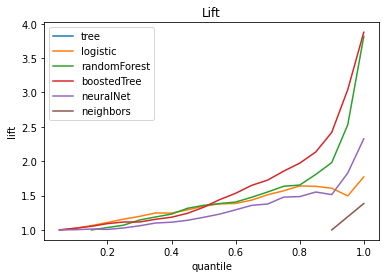

In [179]:
for model in models:
    pyplot.plot(lifts[model]["Quantile"], lifts[model]["Lift"], label=model)
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("quantile")
    pyplot.ylabel("lift")
    pyplot.title("Lift")
    pyplot.legend(loc="upper left")

## Part V: Choosing and interpreting our model (GradientBoostedTree)

#### Calculation of the probabilities

In [180]:
# adding a probability column for each datasets
trainingSet["proba donor"] = DataFrame(boostedTree.predict_proba(trainingSet[trainingSet_features]))[1]
testSet["proba donor"] = DataFrame(boostedTree.predict_proba(testSet[testSet_features]))[1]
# bonusSet["proba donor"] = DataFrame(boostedTree.predict_proba(bonusSet[bonusSet_features]))[1]

#### Cost control

In [181]:
campaign_6169_amounts = pd.merge(trainingSet,gifts.loc[gifts.campaignID==6169],how='left',on='donorID')
campaign_7244_amounts = pd.merge(testSet,gifts.loc[gifts.campaignID==7244],how='left',on='donorID')

In [182]:
campaign_6169_amounts.sort_values(by='proba donor',ascending=False,inplace=True)
campaign_7244_amounts.sort_values(by='proba donor',ascending=False,inplace=True)
campaign_6169_amounts.fillna(0,inplace=True)
campaign_7244_amounts.fillna(0,inplace=True)

In [183]:
# trainingSet
percentage = np.arange(0,1,0.1)
cost_letter = 0.87

sent = []
cost = []
revenue = []
total = []


for i in percentage:
    sent.append( len(campaign_6169_amounts.loc[campaign_6169_amounts['proba donor']>i])) 
    cost.append( len(campaign_6169_amounts.loc[campaign_6169_amounts['proba donor']>i])*cost_letter)
    revenue.append(campaign_6169_amounts.loc[campaign_6169_amounts['proba donor']>i]['amount'].sum())
    total.append(campaign_6169_amounts.loc[campaign_6169_amounts['proba donor']>i]['amount'].sum()-len(campaign_6169_amounts.loc[campaign_6169_amounts['proba donor']>i])*cost_letter)
    
dict = { 'percentage proba': percentage, 'letter sent' : sent, 'cost':cost, 'revenue' : revenue, 'Profit':total}

df = DataFrame(dict).set_index('percentage proba')
df

,letter sent,cost,revenue,Profit
percentage proba,,,,
0.0,34888,30352.56,98653.56,68301.00
0.1,1754,1525.98,49855.56,48329.58
0.2,700,609.00,33372.06,32763.06
0.3,482,419.34,23988.06,23568.72
0.4,381,331.47,19779.36,19447.89
0.5,299,260.13,16207.11,15946.98
0.6,240,208.80,13127.61,12918.81
0.7,165,143.55,8917.11,8773.56
0.8,106,92.22,5929.11,5836.89


In [184]:
# testSet
percentage = np.arange(0,1,0.1)
cost_letter = 0.55

sent = []
cost = []
revenue = []
total = []


for i in percentage:
    sent.append( len(campaign_7244_amounts.loc[campaign_7244_amounts['proba donor']>i])) 
    cost.append( len(campaign_7244_amounts.loc[campaign_7244_amounts['proba donor']>i])*cost_letter)
    revenue.append(campaign_7244_amounts.loc[campaign_7244_amounts['proba donor']>i]['amount'].sum())
    total.append(campaign_7244_amounts.loc[campaign_7244_amounts['proba donor']>i]['amount'].sum()-len(campaign_7244_amounts.loc[campaign_7244_amounts['proba donor']>i])*cost_letter)
    
dict = { 'percentage proba': percentage, 'letter sent' : sent, 'cost':cost, 'revenue' : revenue, 'Profit':total}

df = DataFrame(dict).set_index('percentage proba')
df

,letter sent,cost,revenue,Profit
percentage proba,,,,
0.0,25645,14104.75,18616.0,4511.25
0.1,983,540.65,2545.0,2004.35
0.2,193,106.15,596.0,489.85
0.3,74,40.70,193.0,152.30
0.4,42,23.10,93.0,69.90
0.5,20,11.00,9.0,-2.00
0.6,6,3.30,0.0,-3.30
0.7,3,1.65,0.0,-1.65
0.8,3,1.65,0.0,-1.65


In [ ]:
zfzevfzv

## Part V: Insights

In [185]:
final_uggly = pd.merge(donors,trainingSet,how='left',on='donorID')
final_uggly.fillna(0,inplace=True)
final_uggly.columns.to_list()

['donorID',
 'zipcode_x',
 'province_x',
 'region_x',
 'gender_x',
 'language_x',
 'DOB_x',
 'gender_is_missing_x',
 'zipcode_is_missing_x',
 'age_campaign_6169_x',
 'age_campaign_7244_x',
 'age_group_campaign_6169_x',
 'age_group_campaign_7244_x',
 'is_male_x',
 'is_NL_speaker_x',
 'region_is_Brussels_x',
 'region_is_Flanders_x',
 'region_is_Wallonia_x',
 'province_is_Antwerp_x',
 'province_is_Brussels_x',
 'province_is_East Flanders_x',
 'province_is_Flemish Brabant_x',
 'province_is_Hainaut_x',
 'province_is_Liege_x',
 'province_is_Limburg_x',
 'province_is_Luxembourg_x',
 'province_is_Namur_x',
 'province_is_Walloon Brabant_x',
 'province_is_West Flanders_x',
 'zipcode_y',
 'province_y',
 'region_y',
 'gender_y',
 'language_y',
 'DOB_y',
 'gender_is_missing_y',
 'zipcode_is_missing_y',
 'age_campaign_6169_y',
 'age_campaign_7244_y',
 'age_group_campaign_6169_y',
 'age_group_campaign_7244_y',
 'is_male_y',
 'is_NL_speaker_y',
 'region_is_Brussels_y',
 'region_is_Flanders_y',
 'regio

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:318: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


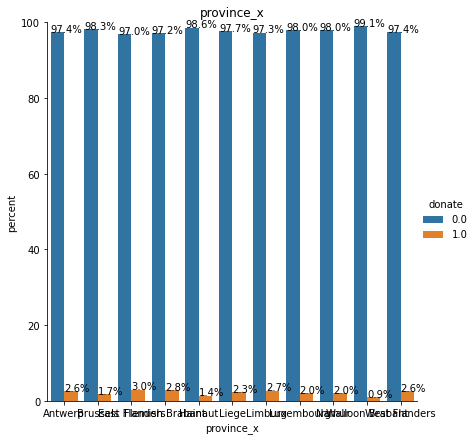

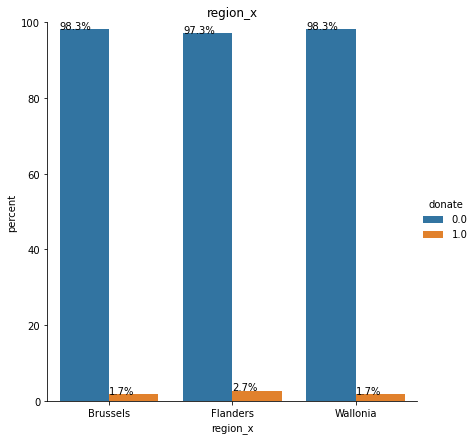

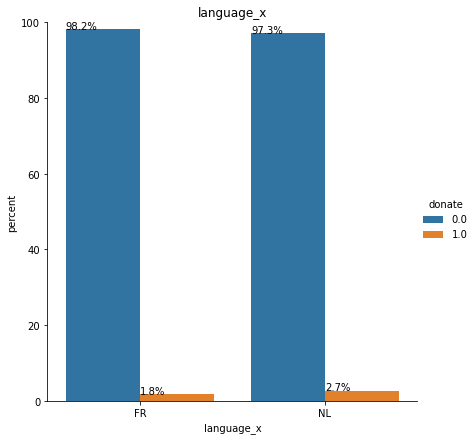

posx and posy should be finite values
posx and posy should be finite values


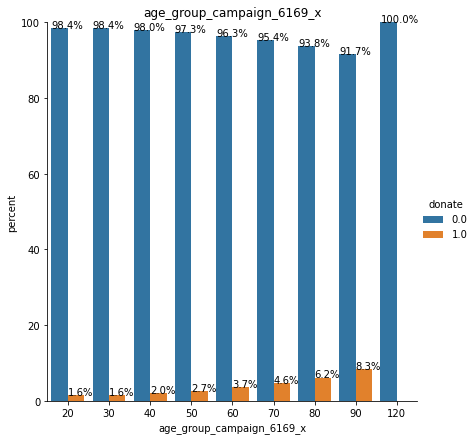

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


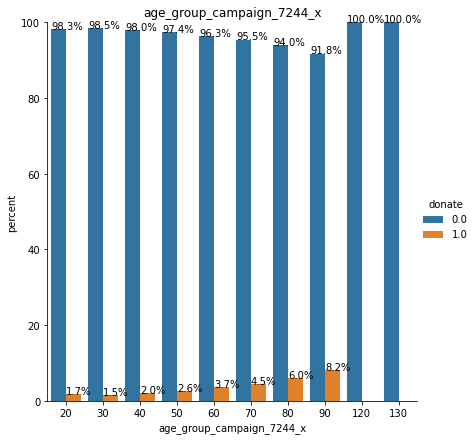

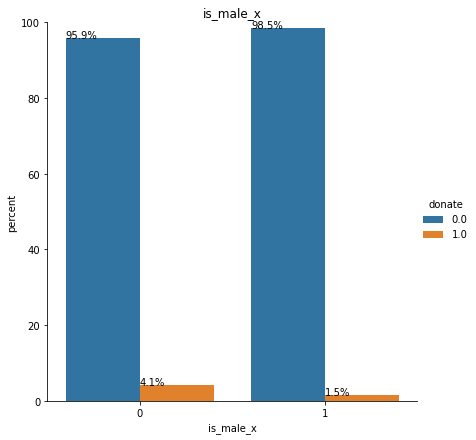

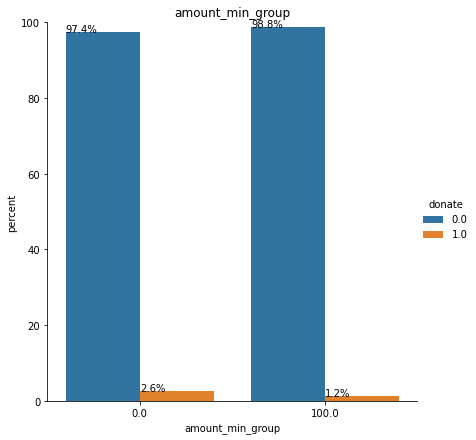

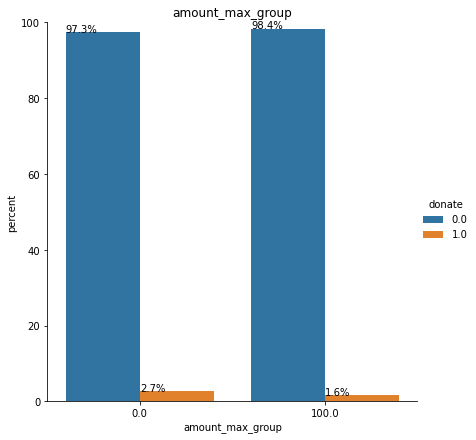

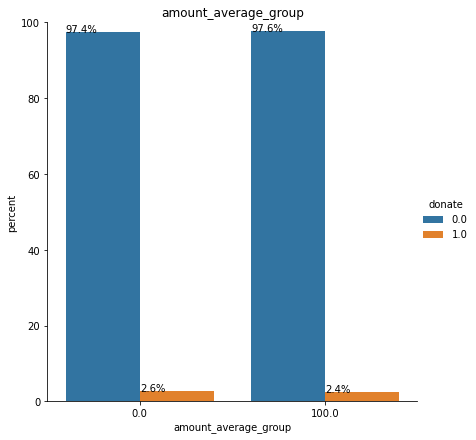

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

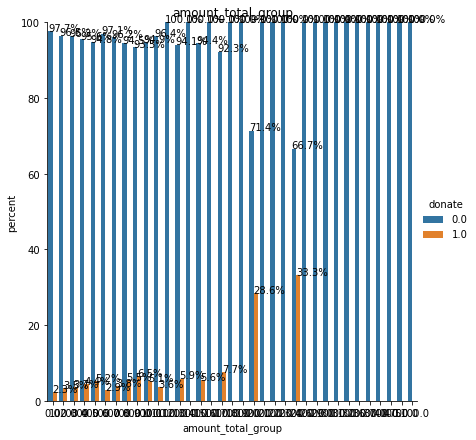

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


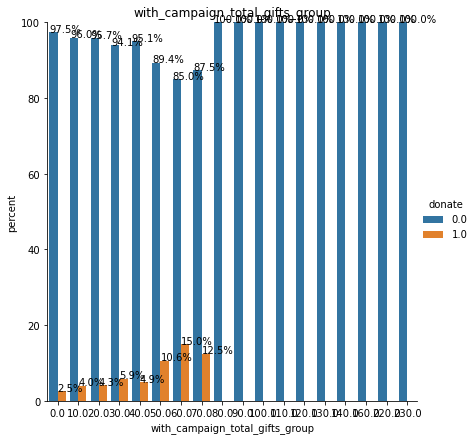

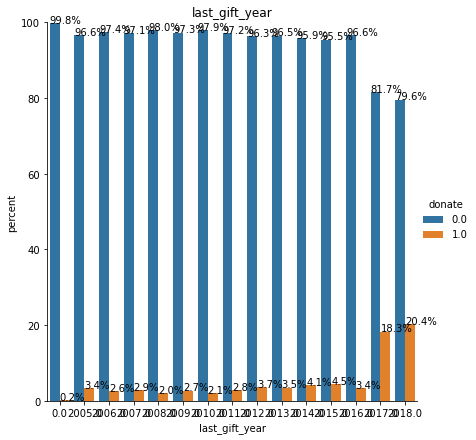

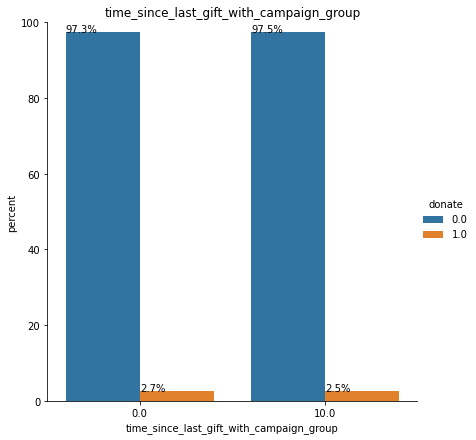

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

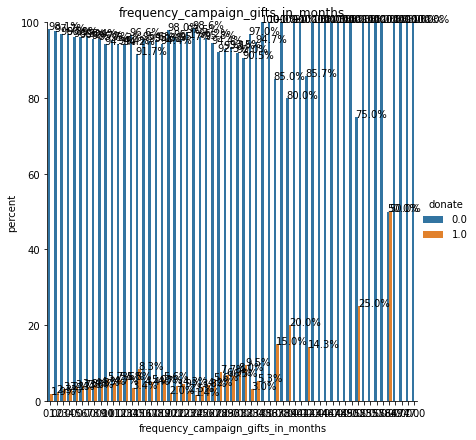

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

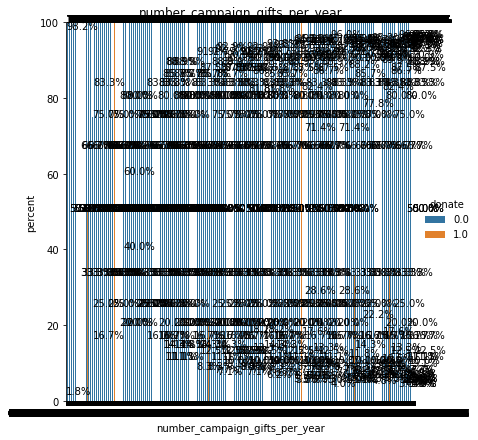

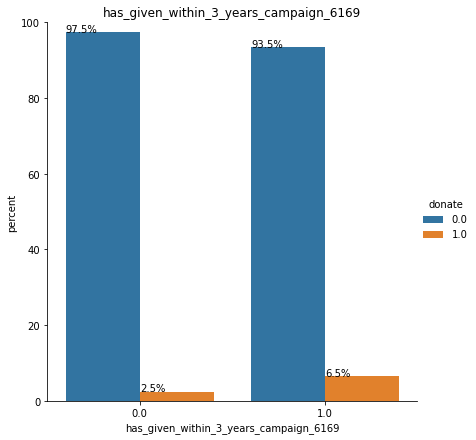

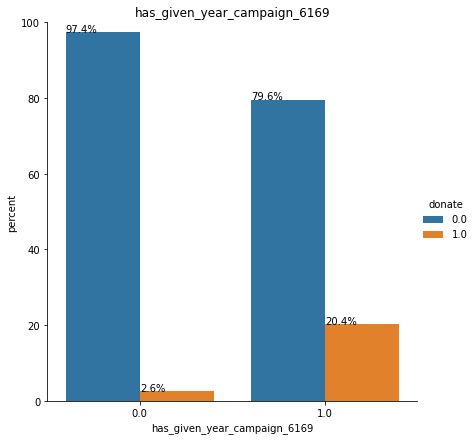

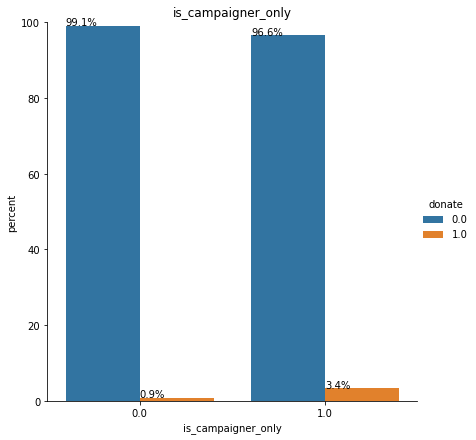

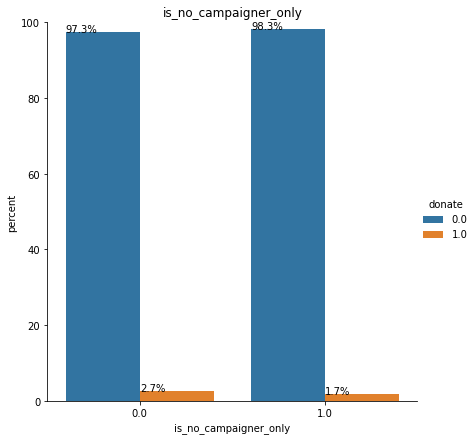

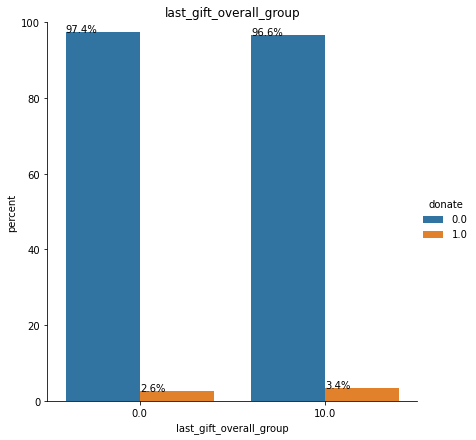

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

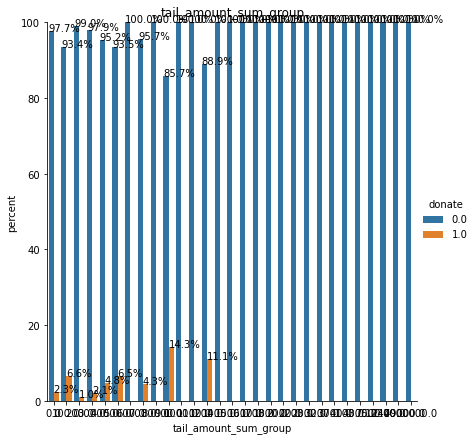

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

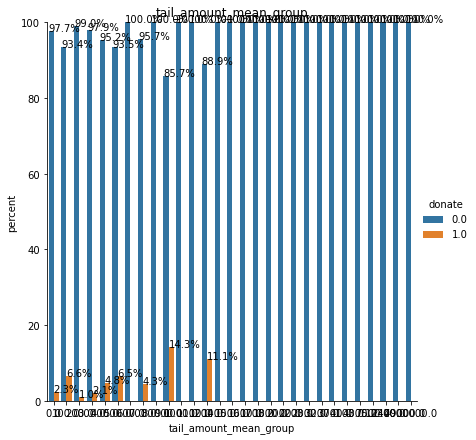

In [186]:
y = 'donate'
import seaborn as sns

final_uggly['amount_min_group'] = final_uggly['with_campaign_min_amount'] // 100*100
final_uggly['amount_max_group'] = final_uggly['with_campaign_max_amount'] // 100*100
final_uggly['amount_total_group'] = final_uggly['with_campaign_total_amount'] // 100*100
final_uggly['amount_average_group'] = final_uggly['with_campaign_average_amount'] // 100*100
final_uggly['time_since_last_gift_with_campaign_group'] = final_uggly['time_since_last_gift_with_campaign'] // 10*10
final_uggly['tail_amount_sum_group'] = final_uggly['tail_amount_sum'] // 100*100
final_uggly['tail_amount_mean_group'] = final_uggly['tail_amount_sum'] // 100*100


list = ['province_x',
        'region_x',
        'language_x',
        'age_group_campaign_6169_x',
        'age_group_campaign_7244_x',
        'is_male_x',
        'amount_min_group',
        'amount_max_group',
        'amount_average_group',
        'amount_total_group',
        'with_campaign_total_gifts_group',
        'last_gift_year',
        'time_since_last_gift_with_campaign_group',
        'frequency_campaign_gifts_in_months',
        'number_campaign_gifts_per_year',
        'has_given_within_3_years_campaign_6169',
        'has_given_year_campaign_6169',
        'is_campaigner_only',
        'is_no_campaigner_only',
        'last_gift_overall_group',
        'tail_amount_sum_group',
        'tail_amount_mean_group']

for x in list:
    df1 = final_uggly.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()

    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1, height=6)
    plt.title(x)
    g.ax.set_ylim(0,100)
    plt.title(x)
    
    for p in g.ax.patches:
        txt = str(p.get_height().round(1)) + '%'
        txt_x = p.get_x() 
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt)
        

In [ ]:
donors.age_campaign_6169.max()

In [ ]:
donors.DOB.min()

## Conclusion